In this notebook, we apply autocorrelation techniques to the data obtained from Venus (or the Sun). We'll probably have to come up with better ways to reduce the data from Venus before applying autocorrelation, however.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pan

In [23]:
# Extracts data from file
def get_data(name):
    # Open the first file and read the first two lines
    f=open(name,'r')
    obs = f.readline()
    wlen=f.readline()
    f.close()
    # Saves wavelengths from the second line
    wlen = np.array([float(i) for i in wlen.split(',')[1:]])
    obs_time = obs[12:]
    # Reads the rest of the data
    dat = np.loadtxt(name,skiprows=2,delimiter=',')
    # Saves time and flux data
    time = dat[:,0]
    allflux = dat[:,1:]
    return wlen,allflux,time,obs_time

In [31]:
def get_lightcurve(dat):
    # Load data from file
    wlen,allflux,obs_sec,ot=dat
    # Convert UT time to local time
    hour= float(ot[9:11])
    minute= float(ot[12:14])
    second= float(ot[15:])
    lhour = hour-5
    ltime = lhour+minute/60+second/3600
    obs = np.divide(obs_sec,3600)
    obs = np.add(obs,ltime)
    
    # Derive flux curves from spectra
    
    flux,comp_flux=[],[]
    for inten in allflux:
        care = np.where((wlen>391)&(wlen<395)) # H line
        #care = np.where((wlen>429)&(wlen<431.5)) # G line
        flux.append(sum(inten[care])/(len(wlen[care])))

        hocare = np.where(((wlen>399)&(wlen<410))|((wlen>380)&(wlen<390))) # Larger comparison window
        #hocare = np.where((wlen>429)&(wlen<431.5)) # Compare to G line
        #hocare = np.where(((wlen>425)&(wlen<429))|((wlen>431.5)&(wlen<435))) # Compare around G line
        comp_flux.append(sum(inten[hocare])/(len(wlen[hocare])))
    return obs, flux, comp_flux, ot

In [32]:
def polyreduce(getlcout):
    obs,flux,comp_flux,ot = getlcout
    
    # Fit resulting light curve to polynomial
    a=np.polyfit(obs,flux,10)
    b=np.poly1d(a)
    # Divide light curve by fitted polynomial
    pflux = np.divide(flux,b(obs))-1

    # Fit resulting light curve to polynomial
    aa=np.polyfit(obs,comp_flux,10)
    bb=np.poly1d(aa)
    # Divide light curve by fitted polynomial
    comp_pflux = np.divide(comp_flux,bb(obs))-1

    plt.plot(obs,flux)
    plt.plot(obs,comp_flux)
    plt.plot(obs,b(obs))
    plt.plot(obs,bb(obs))
    plt.xlim(9.4,16.9)
    plt.show()

    plt.plot(obs,pflux,alpha=.7)
    plt.plot(obs,comp_pflux,alpha=.7)
    plt.xlim(9.4,16.9)
    plt.show()

    flat_flux_fun = np.divide(np.add(pflux,1),np.add(comp_pflux,1))
    plt.plot(obs,flat_flux_fun)
    plt.xlim(9.4,16.9)
    plt.show()

    h1h = pan.rolling_median(flat_flux_fun,5000)
    plt.plot(obs,h1h)
    plt.title('Observation: '+ot)
    plt.xlabel('Local Time')
    plt.ylabel('Flux')
    plt.xlim(9.4,16.9)
    plt.show()
    return obs,flat_flux_fun,h1h

In [33]:
def crossCorr(dataArray1, dataArray2, lag=0):
    if lag == 0:
        return np.dot(dataArray1, dataArray2)
    else:
        return np.dot(dataArray1[:-lag], dataArray2[lag:])
                      
def crossCorrelationNormalized(data1, data2, max_lag):
    data1 -= np.mean(data1)
    data1 /= np.std(data1)
    data2 -= np.mean(data2)
    data2 /= np.std(data2)
    return_array = [crossCorr(data1, data2, li) for li in range(max_lag)]
    return np.array(return_array)

def windowedCorrelation(dataArray1, dataArray2, num_windows, max_lag):
    """Calculates the boxcar-windowed time-dependent cross-correlation.
    Perform polynomial background subtraction prior to running."""
    if len(dataArray1) != len(dataArray2):
        raise ValueError("Data arrays are different length!")
    else:
        step_size = len(dataArray1)//num_windows
        return_array = np.zeros((num_windows, max_lag))
        for wi in range(num_windows):
            return_array[wi] = crossCorrelationNormalized(dataArray1[step_size * wi:step_size * (wi + 1)],
                                                          dataArray2[step_size*wi:step_size*(wi+1)], max_lag)
        return return_array

In [34]:
filename = 'flattened_observation_10-26-2017_1.dat'
dat = get_data(filename)

C:\Users\labuser\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
C:\Users\labuser\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


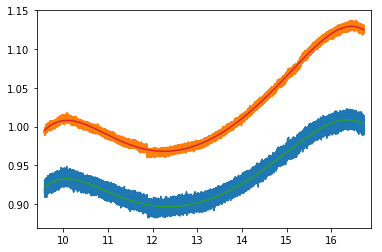

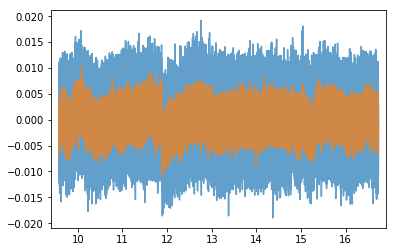

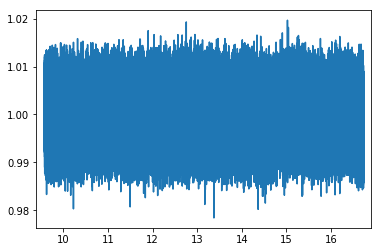

C:\Users\labuser\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version


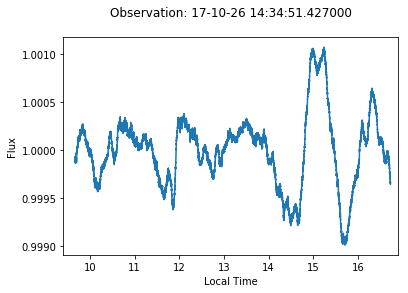

In [35]:
lcout = get_lightcurve(dat)
obs,rflux,rmflux=polyreduce(lcout)

In [36]:
obs,flux,comp_flux,ot=lcout

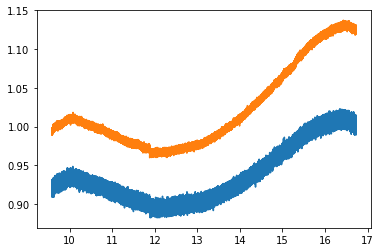

In [113]:
plt.plot(obs,flux)
plt.plot(obs,comp_flux)
plt.show()

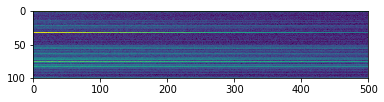

In [99]:
#  Test it:
offset = 350data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYAAAABmCAYAAADCrUaUAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzsvcmvbVuW3vWb1ap2cep7bhmviIyMNIUQTiphRAMJCbfc%0AxdCh5Q6QWDQQgg4g0aDDH+CG2/TokljCEhJCwhhL4DSZ6RfxinvfrU6161XMisZYe92XgBDky5Aj%0AiTOlq3vO2WuvNctRfOMbY6mcM4/tsT22x/bYfvOa/kfdgcf22B7bY3ts/2jaowJ4bI/tsT2239D2%0AqAAe22N7bI/tN7Q9KoDH9tge22P7DW2PCuCxPbbH9th+Q9ujAnhsj+2xPbbf0PYrUQBKqX9NKfVH%0ASqmvlFL/4a/iGY/tsT22x/bYflxTf9Z5AEopA/wx8K8Cb4C/A/zVnPM/+DN90GN7bI/tsT22H9V+%0AFR7APwd8lXP+Zc55AP4r4K/8Cp7z2B7bY3tsj+1HtF+FAngBvP7B72/Gvz22x/bYHttj+zVq9ldw%0AT/V/87f/C86klPprwF8DKBr9u1dfzNFkfDZYlYhZoQCjEgmFJRKyIaEoVCRkjVYZTcJniyIT0RgS%0APhucjgzJUuiAAnIGreT+mkweO6rIJBRORRKKkA2KLN8Zr/HZ4FQkosfPMl1yNGbAJ0Mc+wKQshqf%0Abcgoau0JWROzxqhERmFVRAFDNhgl9wtZTz8rMjFr+mTRKmNVImU13SNk6YdRGa2O303jsxMhaTLj%0AeJP5E/MoY1fj2GScWmVSVuNCKVJW0/UpK7TK5CwzotSnRfZJU+j4g/vBEA1GJ6xKf2LhY9aEpKlM%0AgHFOFXl6llHSryEZyGB0QgEJNd6daU20ygxR1jijGKKhNIF0tGd+sNuOc3Nsx7HmcVxKyVwfW8pq%0Aen7OCqsjIRnyODd2nH+jZJ5/uNnz9Ns4T+OkHNcmjXv6OBB1nFcFMWqZN/2Da3/wec5M9/zhZ85E%0AfDQyNi0DzxlSkvvxg+9M/cxKxveD33NW6HHMRidi0p+mcvxMjfNzvOb4s1KZlBTGHPeu+rReP+ir%0A1omUNFonYtQonSErjJHfRS7kqT9KJ8iKI0qtFKDydN9pToCclHymjj+D0okcNcrIfZTKpKjRJpGS%0AnH55ntxHnnNcuOPkyH05zp/Kn65JCvQP/v/hd34o8Y6fHf+u+fT9T1uGadKOv+sMUYEZn5nGe/zg%0A5sN339/mnK/4U7ZfhQJ4A7z6we8vgbf/54tyzn8D+BsAi9OX+cvPfg/TJ7KGbBR2HzBdwJ+UciDb%0AwHBaUKwGstX4hSUVCruL8j2jMF2gu6ywh0jxcQ9OcXi1QIeM6SIqJGJlcBu5RyoNoTJko6i/39O+%0AnGHaSDaKbBWx0FQ3PbGxxFLjdoFYGkwfIYPuI9pHkjOonEnOMJw6tM8U9x2ptJhOvqNSpr8oKTYe%0A5ROhsagMbt3TXdfUb3bEWYEeIn5ZYvpIqA1oRWg01c1AKjRZKdxDh8qZrBRx5vAnDrf2YBTRadzO%0Ao/rI4bMZ9duW/qqi+tiRrGb7ec3i25bhtMAeIqYL6C5M94qNxRwCdtvTvpzjNgHTepnzuQOtiKXG%0AHiJu3ZMKQzYav7SokKk+HIizgqxlDs3ek42me1JSf+hkjk4c9hDRQyTMLPU3KzCaVDva5zNMn1Ax%0AEyuZczUkVJR/sXYMpwX1+wO69QxPZughybwtCkwbSJVBDwn7cCAXFtV7/OUc03rpr1bYbU+2mlg7%0AstXYbQ9KkbVCpcxwWlJ9+8Dw/HSa6+P+0SHj7g/EWUmqDHYn99VDRPnIcF6jh0hsLG4zEGtL1gq3%0Alme01zXNdxvCSS179qqieBhIlQhy0wZibbE7L+ux93JmrMZsOlLtSIWVOfEJ5SP+qpEDvemJ8wK7%0A6ojzEuUjaEUqDSpkyBkVZC6z0aTC4BeO8qHHPBzAaMJJPZ1THRKkRCos2Sjc+zXDyzP0ENF9kD2+%0AHyBmhusZKmXszouc0krGseoJJyWmC5htT1aKXFmRuimhtx3hyXz8PYNWqChK22x7UmXRXcBfNug2%0AyL5ZlGgfyUYTS4M9eLJSaB/RhwF16IgXJySn0W0Ao0iFwX7cEM/n+GVB9d2KeD7DbHvwAYxGbfbE%0AZ+eyR242pJNGzqVP6NUetCZczHBvH4hXC1RIIksKix4Cen2AsiAuSlQf0UOAwaMGj3958Wn+fULF%0AKPt8Ucpc7wZS44iNw+4GzIcV8fKEVFnc23va335CsepRQ0AdetLpjL/13X/y7Y8R1r8KBfB3gJ8p%0Apb4Avgf+deDf+H/zxe7CYnzGbSM6JMJ4oI+WlNsFspGDWN52ZCeHLswdehTwxdqjfSQuS0JjMUNC%0Ae7GEwswSZiJUTRunw+7nmrgsUKOiQCnCzNJ8fyDMC1TM2H1kWFrqdy3+tMRuPboLqBihtPRL2STF%0AxhOdZvvFjOVXW/qrBrcZSKUc7lAZykPAtpFYGrLV1K+3dM/mqJgp+kDWyAErNP3CMvtuR3fd4PaB%0AWBvisoCY5ZohYjpDKg12O6BbUCmTakvzeo8+DBRWQ87Y1YHTP+jJzlC9C3TPG+xuIM4KVEyYPuI+%0AbMBZiAm39qgMyRns3Q5zm8hVSa4sYVGIQDp4wrzAtAmVMoSEvd2R5iVoTbKa2FgW/+sHDj9/Qnlz%0AQM0tbtOTtaLce9K8JDuD2fbM/ugOFSLxbIZuCsxhEMFsNXiw2x53tydVBeGkovz2nrSoUfuO8lCQ%0AKgt6NKNiIisFThQwSmEfDqSmQLUD8WIugnxeog8DuXTgDPowULWe3JTYvYeUMPc7ui8uKd/vUTkT%0AlhX2fo/qenJTiVGnxYotbvdkY0Tg3e8wzhLOZ+jWo9qe2fpArgtMF1Ctp/qQUH0k2xrdB8zDHl0W%0AhNMK925DbkpSYUQBjXOl+0CsHW67I5eOWGjqb1aofkAfSvzFjOL7BwByVZDPZ5h1h94dyM6SThr0%0AwcseCvJ8gLisROE7I4Km84SLGXbVkgsRF8W7DdlZ0GA3LbkpwSiK2wN6cyBeLNA+kSoxClIlhhAp%0AQ4gorVDrgXC5wN4dyE2JCgmz60m1A6XQmxa12ZGXc7QPpEWFfWhFoaWMahz2mw9QleiLxaSI/HmN%0AC4lULmQvrg+w3pJeXmF/8Q5VyVwWdx2st+jCodoeBg/WQDmerS6QTmaofQfzEvNxRbw6AaVwX38g%0AvriUPoYIg8fkTJ43015NzlB83JDmFelshj547M2WXBeTu5EqMajMticsK3JlZb+sjeyr0qH3HeZ+%0AIFclxUOHbr24KsZgbjc/Wlj/mSuAnHNQSv07wO8DBvibOec/+H/6jgqZ5ts1wxM5kMPVTKzqkD9Z%0AxF0gW4VK0F0WuG3EdBG92pMXZ+gugNX4ucVtM3Y3kI0WS0Ip3Js7+i+vqH9xR//ZOXbbo1c70skM%0AM9QUf/wOfvsZpvWgFMV3t/gX55TvtzLhPlCWBWq9Q8VTuicNzTcHUlVg9gNOQfH6jni5RBWW5V1H%0Aahz11w9kZzEadFdi73aQEmpW4b7dkKsC/+KU+s12tHA8VRfIzlB8f6D4aFGbPVUCvWtx1qB2Lbmp%0AZL4rR/VxTf/FJSpl9GEAH1B1gTr0oLX8vfWkpiAVFvfmjnSxpPrQovc95Ex2Riy9eQ1WY243FN8/%0AkFcb1HJOOlugb1ak0xnZaooPO+KyQt+u0cU5xS/ek56coWIkntTYDyuys2hnsfeZ3FSUdx1629Fs%0AO3IlwjY7LYdg3aJ6T7xYiNcdE/ahBaNQnSc1Jamy2E2H2rVQFbjvbsmzWqz8waLu1/D8ArPtRFgZ%0Ajd53pGWN2XaomMmlw9xuyLMauzqQnSEVBhMTerUjb3eo+Yx4uURvO/jqO/jZZ+TCUf3RO3Itis1s%0Ae4iReLkkG41ZHeB+jZo15GWD7j28/UD82U8wN2vsbUL5QDqdo3oPv3yDfvkUtdkDkFZrXHqBanuy%0As+TKivWdRamaQ0+ui8laNO/uURdLUArVe6r3e7G4Lxbo1lO8XZFmNfpuRTqfj54Ak5LSrz/CyQK1%0AHQivLjB9JFcO+35FLhzUBal2mCHgvruFwkGIIqzf3aG0Iv3kGr3rUKudKAQgXixQXUDvW8LiHHe3%0AJ2uNurmHkwXhci4C+N0Gs+/lWSGhUwIf0D4wYT5NLXN2MpM+b1uy0WAMdt0x/Pw5xTe3mA8r9KIh%0AVQXF3/sF6acvUTHLfjptMEajNy356hy13VO8XeGfnWJmDckZ4skMvT3IGIHUONz3WzEglqL8UApi%0AJjtFntWYuy25cGI0VIUo5c1hmgd3t5fPtMbserhbkV5eodejwvMRM4hSzM5iDgP6di37uS7IzqI+%0A3KGaCowBozH3O9KsFmNpvSdb86Pl9Z85DfRP05az5/lf/PzfIi4qstHiSrVeDraP4l4derAG1fZi%0AHW5a+b/zDJcz7G4AwOzF/QtXcjABsWhGsFDFiL5ZkZdzUlOiu0GsndGV09uW4cUZpvX0lzX1L+/x%0AT08wuwHzsCU7S/+TM9yqQwVRLuGkRA0JtMLe72F0X+P5DOWjCJKUiOdzuuua2VcPqF3L8NmlKKL1%0AXgSDj+y/PGH+d74lzxvSSUMqLdon2XBGi8XR9fL5ssZ8f0s+W0JMqMETr07Qmxbu13B1RrYa1QfQ%0ASoSiUiLomkoslabArFuZm0NHntUQIjgrwui4yZxF7Vvi5fITIB0zWC3CJcjzc+XQDztwVizzdiDX%0ABXrbEk9msnGNBmfJzpC1lr9pJdbT+xv0xZn04/U7eHKB8oHD71xTvd+jhgBa489qiq8/yqH1gbxo%0AxI0HVO/JbQtnJ3C/Qi0Xcs3JHLXaTgc9V4UoE2dJH27QpydQOHJdkkqH/u4d+cUTsWrPFrKXVjvp%0AZ+nGOUikeYn5sCJ3Hcpa4sMK8+KZzNso0LL3cH4iyvHbjwCkhxXq1XPUdk+6PJPrR4WnfPgkmFYb%0AGUPOIjDv16TPrtFfvYbrK3j3EepKlM/R6PGB3FSorqf9+TXV//QPyT95Jnt2XF98+BMCVrUD8azB%0A3G7J81oU/sUSfbcRWON8Lvvt/AT6gXi5EJjj0KP2Lbnr4HSJiom0bGQc+5Z0e4d+di3z3fakmzv0%0A+Rl50cgeMxq1bz8JfufIhwNYi9J6Ulrx6Rl626G2e/LpQpSns6OSjLJ2qw1q1kAI5JzFso8RdXEm%0AQnW7l7W4vhSDwVryMEDbwYtref7tCjWryYVDDWIQ4oPsm8HL/ljWmI9reU7Xk0NAL2WPpMsT1Ldv%0AUednsq/XOwiB+PCAfXot+2T8THUD2XvyoUVdX6LanvD2HeZnX5JmFXonHpZ684H88hrVinxDKfJ6%0Aw++v/+bfzTn/M39a2ftrowD+0rN/k3C5QHeeuKhwv3xPfHnFcFJQftwT5+UU8bEfN6R5LcJ8c6D7%0A8oqsofrmXiar8/jrJe7jVh4QowiFuiTX4lrrVoRFtlqE4kFw1jRaXqr1xGWJXXfiysY8Wt6ivbMx%0AYlElSPMC3QXirMCsO1TXo0IUoT4EUukIpyV21WMetrS/dUX1dkuqHXrXkxbVhIemUiyIrAVvzfNa%0AhJ4XwZfrAoDhoibUhubNDkISJRYjer0X4V6KkFMHub8+DKjVlu4fe0H53cOfcEVVzKj7Nfl0IfBI%0AEAWmQkLtDiIgklhGZt0yPFtSfncvh3zfkcuCXNnpe+GkRPmE2fRgtcxxzOhugPe3qOVcLOz1AYyR%0AvoQEdgzGpgQJwmmF3XTTOCgcqhvE8j5fYm7XIviBcFpjDh71+j352RNRTPtOPKBRYWaj0Dcr4tML%0A9JuP5GcXMj9nc8zdFv/0hFQYym9uiWcL6e8oWKZ+aU04qcSdL2UtVEqoQ0eaN6hBhF58eobyEhNA%0AKTFKnpx88tKANCsxd9vJoFHdQDqZo1ISI0Ir4qJC+QQagRxHJaxXexF437zB//O/Q/H3XxO/eCow%0ASulQKU1KVyXZH7r1MHjS6QxzsyZbI/BSU5BGWEnFJOsCohhnJeZ+R3iyxDwcBA662cLNHersVDyO%0AwyCC7Cjsrs5EoIcoCuR+KwpdK4EFa4de7YmXC8z9HhUiuRKPAy3WOilB4eiezSlWPXrTEi7m4nlZ%0Ajb7byD6vHFmLpxdPG8zDXixoY8T7W1QTLg+IAZCSGE0+COyjFKl0mPsNaTHDXzYU369E4ValQHF3%0Ae1TvZc/7KN6Qs+h9S//ZBXqI2IcD/bMl5f/yFem3Xgnkt9oSXlxg394Tr0/Ru15iMlWB3h7IVYne%0A7kU57Vv8F9e4724Jz88xq4OMzxkxIoFwMSc2luqPP5Aulvy3f+8/+/OvAOZnL/Nf/Eu/h9sHzEFw%0A0Vw7ussK0yfcphf8s3aC5Y8B1GyUBHSVksCRjxI36CK6Ewu+vG1RMRNOSuxDS1hWmC4Ith8SGIW7%0A2ePPG+y2nwI+yWmy09hVh94c8M9OIUNsLHbvSaUhlobyowQ9AXH1gP56Rv3VLURRAqkWwYkP5Fkl%0AC3oYxMrcizaPZwL/qJDor+e4TU+s7OQhHH7+hOYP3smmb0qx7IMEvycKg1IC6SiFv5ph9n4SNsQk%0Ah2GEX9QQSPNqxFRFsB2D0Ob1R/wXT9EhESsrsFjM4oWZUaBrLRDavAGrp0BdNoruaUPzy9XkWZGz%0AuNNNOQn6bBQqZvonDfU/eCeC/H5Nenklwcna4r5fiWA5WvejAvTnNcWbFfFsJgJr2wk80hTkQtYM%0AEO+xKUTwjd5BmlWkWpSVPnhUSqRG1i85g/v6vVi4PpCWtSjoppSAXR8+/dz56XDG2lG8FcgLa6b7%0AmY8r/PNz7OqAv5xLHGLcJ6l2qCi/x9IIZDMXxa0PA2q9k3VTirxoPq23MyL8TuaynwqHXm3luqog%0AN6XEJ7ayF9V+nJtZiV0diIuKVFqK13eTAlA+Tl6r2u7JC/EIcuUgIVaws2II9VG8lHYgzSrUCFFl%0AZ0Rhai1Bz5jIpSOcNuLRb1rxaJ3BbjriopSAdlNgbjcTNJZLh2qHT95AzuSyEAgpRvLzK9TrD/BU%0ArGXZVwKHxrMG+36Ff3aGe3tPLpwYij6SSyP7c4Rq0rwSVg2gdwfZW5starkgLcWo0O/vBNYMSWCs%0A0WMSyNROxpjq/OgRrASuyRm6HuqKXB2vGcQDfhDoCBAIyZlJ8ejbB/LJAtUPMq66nDy0IxKiYkR9%0A8xZ1siTXJb//R//Fj1IAvxa1gLTPuH3A3R6IjUX5INhiyhR3B/xSNqn2Ee0T1bsd5dsNxY1AF9lq%0AdCebrrjZY3Y9sXbUv7gjLEXo6FYCWnbTQc64VYfZe3nmssLuBg4/WYwucsKuWtzHHam0HH7+RATj%0AYcAcAubhgHu7xrQCfZhdT3Iaf16DUlRvNgzPT0VYa4FI/JM5/umJYM6lxV/MMKsd4Woxbfbu6UwE%0AqU+C437/IJvXWcrblnwyJ5009JfiFejbNSTxFlTMpNISzhr81QwVMsN5RVxWEnBa1ujDgL+aM1w2%0AcgDG58ZFRTgpcb94J/O5nJML6be73X2y3nMWKw0mvDPNC/R6j31zRxyF2ux/vyGcNtNBTuMhOMJE%0AqvcoH4mzgvLDnvhU4I/0k2tRghncx53MV1OJZXw6mwRu1kpguXUrsY2FCAB7vxfhnzPhtJo8j6wU%0AaVERrhaCve4HdOfJlRXr8fXHSTClJ2ejV5REMC0q4rwQK7aUwKeKefKczN0Wd7MjXC5QgydVltjY%0AiTFiVwcIEXd/wH5YC0SYM6SM3rToTSvxqrpEtYPEJ5TgzHlWiwd4hClbCRZiJKiPNeTKki6W4nEc%0AOjFwdoNABb0nzyr03Qa7EdKE2fXYdSuCesSww7kI/LSsSVenIqCUEm+yGj3SkQWl71ayrs6KF2UU%0AqXGyP47Beq2J53NSVeC++SCe5CBGhL3bibH1+na03HvxnA697It9hxr8uFajl+4MylrSq6foXQfP%0ArlDbw2ihFyKIYxTlpBTu3QN53qC2e/RuhDf7OMVPhhdnch+jRIH5QGoqOF2KUXQQ5ZnnAmORs/TF%0AaFGaRosR1Xn0VqAr83ElXmbpSIua+PJK1vQg+zHXJeZmRbxciuLct7IeHx9IJzP653P5vrPkpiKd%0AzAURmNXo1Q612WNuVqKovnwp58n9+BDur4UCAHBv1/RP53TnBbm0+Ms59hAZLhqK+5ZwKtS0rGQz%0AhrOG7DSHZzXDqSOOll5YVhP9svvyguRkiGFeEC7m+IuGVFixegH6QeCbxlG/b1Epi7YtHcP1YmLH%0ApMKI6xoS3WenpJMGcxjon0pQ1K069JAIi1KsKaPwT+ZkJ4JU90L5YhQe7v2aeDoXATnGPupf3ovQ%0Avdtz+Gz5Cac/aSSAaQQCK2+EghheXgjNTIsHoPsgNLlePKDy/U7YJcbIPMSE3fYUtwfCzOGXI7vE%0AR8xmIC/H/swq7F2Lfth+isPMSvyThcAQvRyYcCkClcHjX11OHkBaNth1S7haiPA3CqwRBkrhJBaR%0ABMqLs0LmdlZi3t4JZmw1qvcS1zGa4eW5CMu7DbGyIy1YqHWq7dGtR6/3hEuB3FQ7UPzyRqAtH0mN%0ACDSzHVkwhZ3iN+rdR9JPrrGrA6l2E200VwV5f8DcrGVOLk9QfUBvBRLsX52JMioLCTZ3EsDW2w57%0AN7JDUhIrVSmx+H0gnM/on84x247UlOL5vb+DfsA/PxF4Z9+K9W20QF79INABYHYD6XQuQvHQofe9%0ACHsfic8vcPcHdO9FWcUkQnzeCBauNXnE09O8Ehrq2ztZQ2cxtxtUH0SRNSX+xfkkvPXDRgTZ6YK0%0ArOV+5yfjvhShnwtLLizxpEZ1AXO7nhQqRixdNYiXmwdPmheTt+SfLQUGOp2RFjXu7QO5LgUW7j3h%0AxYUE1nOWuMHJnLwXy129+YDaybhlbI1Amsu5KKqtsLXM/R794R67bsnV6DEqJSyufSvxxVmJ2rej%0AkSIeFh/vROCPSgeQONcoQ1Q/iOX/+p3EVYJQc7PVwhzyQeINQRSa3neki6Ws2ZMz1KGXGM2IDnDz%0AILBlVcr/1kicwojXTUiki6XIsR/Zfi0goNnlq/xP/Sv/HjpkyDAsNLbN6JgZZppYKIzPmF6EoBky%0AyYDx4/VzzeFac/JNJFklNMqQ2T8xLN4G+oXB9hkzJNpzCWqWa6GGRqdwrSyk7oV7Piw0ZsgUa8kJ%0AOFzJd1ybsV2SJJ4Ito0MJ5ZkINQa7TMoqG8DhyuLazPaZ2KhCJWi2CeSUfiZprqPhFqhI/haPiOL%0AN9SfGGbvB/bPCspVxM8Nbh+Fq1+OTKgzzfxtmPoaSy2c4kKRDbiDzFEsFdqDGTJZwzEnKmuoP/T4%0AE0eoNCqBPYiS2r0oaG4CWSuGhSY5he3yBGHYNpGcIpQa2yW6M4M7ZIp1GD0RzbAwqJjREcw4Zygo%0AbztSbRmWDtNGVIJYafzcUK4C/amlvPekQk9KT4dMVpDcyGgaEjpmQmPQPpPsGOAfxxYajd1H7D7Q%0APSmpbgbJU4hAzsRa03zfsn/VYPcR7TPDicV0SXIX+iR4dh6V7nhEYiXPV1GeUd15UTI5EyqDPUhe%0Ag915Ds8rynuP24x4f2nxc4Euj7ES00X6iwK3k3kPtewzP9eU60hx0zJciHejY8bPLMXak63Czyzl%0AfT/lc/RnjuqmR8VMd13itpFYjXsyHc+NjCsWGttFklHibd0LYy3MLKHRuK2cI8nFMBRrj31o8ZfN%0A5P2k0mDaQHdVUmwCsdDiiWaZY7sPck0ndGu0GG5ZK5KTvphW8k9SaeQslgbbihEjrLRMqiRXp369%0AJVzUEotyGrcdhP49SG6G6SL64OmeNVMeifaJ/kxyRvyyRMcktORST8aU20q+UdYKvywoVj1+7qhe%0ArwU6qx0qZ/RuYHgyI2tAK8qPB8KixG57Di/nNCOVu/5WoLzuSUV5IyhGcrKu2WqhMDcFw2mJ6RNm%0AN4AGc7+j//wCFeQsZ6ux+0CYWao3W4FNlSKXRryxnImV5W//7f/oz38MYHb5Kv/T//LvyUYBinXA%0AL4wI512aBE+sNb7RVHdBNrNSdBfjoUpQ3nv6c4fdH4VmYliaSWBlBfXtQKhEOKGVCI8xnmDbKAs2%0AHgw/N2MSWcJuB8y24/D5qeQVaIVb9cSZIxk1JaMdM/liodFBhFSx8eg2kGpLqC3FfcdwXklSx/FA%0AFYb+omSYaxbftGOMQYRgcdcRTkqGU8vsmx3kjD+v5blekkrMfpBA+XivVOgpqc3uBvrLWhTDJkh8%0AQ4PpJbioBul7mI0Uto0nFwKfhJnFbbwkUR2D4a0nXNSoIdFflMy+XpOtnvBw7YVTfozN6F5iLm7V%0ATfzyrCX3wt0IDdJfzIQDvx/wl41YuiMDyi8KdBThlZXCbQdJrotZchG6gHn/IHz48/mEl6uMWOF9%0ARKVEOGtw71bC8joMxKbAbnu6pzPq79aE01qC/k0hmHVT4s8qyvdbgdWGhGn9lOhlVx3hbOTubzsJ%0AvOeMvt/if3I5wkhb0tkcQLyTIcj9t50kv80r6WOUddOdF7z+fi+fj8F8vT2QZ5XAcft2hApkvfWH%0Ae8Ln1xJ0Hj2bVBg5F0P4dNByJs5LzEZyQZSPhLMa93Hkp+csa1OM0Nihn6AmWaQR/57XEhd7eoK9%0A2Qqf/1buoWJG3a3wXzzF/sM3cHHG8HxJ+bVQduOs+BR7qZ2sTdfL2ICwKHE3uymQrjetsP/2rQSS%0AB4G1VEjw4VZiW7/1UhTc7ZZ0Opvmlnc3pC+fYz6uSecLoVnOBd/PdSFB3VmJ+f52hMMKCcT+5Aq7%0AOqAeNuSzpQRsR0aY+nCPakY0ohEYNVstf69K0mKGykKqiC8uxYOMSfoO4lVUxQQD5tKi77cCLzkr%0AnkQakx4vFvLzmP/hvr+X587qCY79W//zf/rnXwHML17lf/wv/3XcIRFKzex9T3/qJovO9JLM5UcL%0AxbZJrK3aEEslwqsSK1X7jD2IAEqFFrigi8Qxy1LFPCUFZQOh0pg+U2y9JGYpUTR69DbsIeKXBtN9%0AsqCzQRSKVmI1GsXh0lDfR+w+0l065q87usuC8m7An7jRaxAPAwWmy7itp7sqJuuYLJ6LPUR2Lwqq%0A+zgFS1X1eSm1AAAgAElEQVTMYgkbRfHQ0z2pSFaNXhH4mRmtKpmb/sJhdzLuo1VX3kl2cnsteRTJ%0AaYq15/C0wLbiIQ1Lg9tG3C5weFqikiSWVTdibZpeAuS7Z5ZyK5a9beV71X3Az0ar3CncNuCXFj2M%0AfdfiKdk2EWotlu+oaO0hsX9qWbweJNhea9wmMJw46g8t3ZOKUGnKh8D2VcHyO4m7qJDJVpGMZEwf%0A+2s6EYTaJ3SQvaODeAux0mJcHJIYCwuxQO0hEUtNsfL4uWSaS1a6GBSmH93/kAmNplgHhhNLsQqE%0AxoxCXKEilPc97dOK6k4Mjur7Hf3T2ZRJrX2ePNWsIFtFedPRX1WS0RrGgPGYdZ4KPZ2B6mPL9osZ%0Abp/Eq72wzN/2JKPRg3gVs293dE9n2DZ82teVWL5ZQfO+Zzh1mDYRZga3k7G4bSQWmmI94JcFdrTS%0AQ2Mo73v6s5LqphWywpOGrMAMYqQdrkvx3kpN80uxhP2ikIzufSDUFj2MFOlaj9ngCd0HstV0VxV6%0ASKRC47ZBqh8YJf3bRkwb0CHRPq0pVn7ytjCKUBlipZl9vWG4kozkUI9Z/m/2+PMKtxnoz0vJJwqf%0AZMDRw7OHOGZsd/iTCj2IHOkvC8rbQfJFekngVFnur6TKBNon3M5PGdfJaYntWE1ohLxynNfhVM68%0AGRKhkbmX/QNuK3vv6IXag6c/L7EH8cqKlZBD9BBJpeW/++//4/8fKICzl/kv/ku/hz3I5JY3BxGW%0As2LC0lTKhJkTiMco2VCVWLr12z3d04bqQytZqQc/HSRZVHGhlU/4haN+vRV3ziq6M4vtZLJnr/cS%0AxGKMMyzc5MJ3lxUqZtzhE1MpNQ41Zjwylj6IY8zB7fyUaaxHNy/OyjG4mnDf3uA/u5oyhLNW2L2f%0A2E6m9QynJXp0CW0XIWZMH8Wqy1kodYWRkgB9lES40wpz8NKf0VWc7r+WgFT/TPjK5XsJyInVyKiA%0AEv2FJG0NJwXV6/XEHlJjsCzNi6mMhj1E3DtJrPFzS/16i4pxwoOPlnR/3WB3njB32Fbm8FhiwIzM%0ApVSOGcZK5s/cbvEvTlFDQg8B1YvFegzAptKg+4h7vxLLf4QN4sxJCYoxU7m7brD7gLvbE85nwtbK%0AWfDnJMmGWakpuab98lwIBJeLKROZkIjLkuw0ZjMIG6MdJmpyOmkmaztrLTTM++2E9Q5XM6GpRrH2%0Aj16Q6gfi2Qz7YUU8X6J7j7+Y4d6NAb/Ryg/Lakqqys5IANOLENB9QH98YPjpUyE5jH2KTTFZ5ihF%0AbArch7Wwh0pH/9k5xc1eFOW2xV+fYNctw5M5xYetUClXW+LVKXp7kLiGHr0WJXkl5t09eVYTzme4%0Ar98TPr8mVlZiETcr0tWpjMNq9GGQTOMxEH7MO0mzSijGf/cPyf/kz8ST2Xfw4Zb8+XMJ2I78+/z2%0Ag/Dt60pyVNZb1KwhLWrxjrZ7yTh2Fg4t6alQfdW+JZ0t0evdxOM/ekzqbkX2HlUUUJWkWS1U3HGP%0AmI/riZGTR9ro0SPJlZNAcNuRz09Qm71Y6DEKhj9a6nq1l4D+fjxHN3eoz17IM+aVkF4eNqTtDn16%0AQnh1ifn6vcRaLk6FxpoS3K7gdAG3D6iTBf/N1//ln38WEIDuBR/PGuK8YLioJSM0ZfzC0Z+Xk/Wg%0AYsaue6ll00rk33SJ7klN+d097bMau4+U971AB0YJ7GE15UNPmheU7zb4mWH5ix31h06w94uK/qxE%0Axcz28xpzGDFKd4SMQPlEfy7cYLTCn1UM5wWpkJokxV2HjiNmeCpBJowizqVuTNZilfrPhVnk7g64%0A+xbTSU2hsCiIpSaVFjuWqyjvOnxjCTNLLA3+rJb7FWaqxRPOahFinQSFdSc1fJKTMhHZaPxlg7+Y%0AEWoRnHFRYg4D/qQQ6mVp5PBu/chiUYSLmcBTL0/Y/4UrwkUtOLLTFA899qEdg9SJ+u2OXBr8xQwV%0AEsNZiX+6EJaIl3o91Zst0ekx21diJioIHGAe9mIRhkyyWvjqh4D2cYJxVEhiZY2KbTgtGF6cQWIM%0AQmuplRTFKs1K4XaCR6emkPINo0AeTgrhWluN3rXEiwX+eknzxzciQLTQHQH650LjdO82E70UKzkM%0A3edn6L3QdYUFA3FW0P/0iUAt92vsbkAfvAjsh60I4coK9KGPgchuVB4SNM2Vk1pFP6DTqhjR3UCs%0AjkmS8lm6OhWueuclt6G0wvYZk9biXGClbA15OZPgaBCqpigVi3t9i1rvKG72Qpfct8Jd7wZUiAyf%0AXQgP/iD1aMxrSWhT+1YUZSNC1f6PfwAJ4vML1Id79MN2IguYu5He+uF2Kp2gx+Cq+uIV5m5LKozM%0A/9MrYdU0FcQID2vU82sRvJutQFMnC3Jdorcter0jXp1IAN8aSShTSubx6ZlY7S/OhcBxtxXhv9kL%0A7ffpFfl8ZJ31gxgwzqC/eSdJi5UTaudmJ0SG5UyCsrtuyv5VDxthtMVIWjRSJibEKZ9Gr3bS566H%0AL16JIg8R/fVb8pv35MUM9eIp+WSOeTignBPGU4jQD2PukZLEwZ++mBLkfkz7tfAAquev8s/+6r8v%0AbmoJpodUQHWX6c4VycrfsgUVYPEmsX2lMT2YPhMahd1nugvF/E2mvVK4/RisqxXJQajBdmBaGE7G%0A595n+jNx2VUElWH2LnF4oqeA7HCqcFuBbPozCWZpIWQQK+njsBRX0vSQHLitXFvditKIhYxBBwgN%0AJAv2MP4+kzG5vcQezCD3Kx8y7ZMxgNszCsqMDp+CnWQYlmqCJkKjyOO9AWbvI4dLgZyyVthW5uT4%0AnVgpTCdwTbHJHJ4qTAf2kMkWtJf1AJmfZBXFNhMr6XOYqQkak5iC9C0VCMunz2St6C5kjk2XURn6%0AUxmfGaA/USP8IvdJVlFuEqGUvycHxSYTKsXsY2R/bcRIKBXNTSIWiljIdfYg8Fw28ny/kOckJ0F/%0A4zOh1IRK5hk1rnvK+EZP45h9jHRnZoo9qQShlDU+zn8swbYZ22X6hcyx9rLPBIaS35OVeejONaaT%0AMaeRvJEVFPtMe6kp1tJPM8gaxUKC/bb/BJ/1C43tM74e4c4IvpHxFzuBt1SCYpfwjcBi5TYxzDSu%0AlTnNWklAeSQgFDuB8UL1qRCeyjJe22fcPtFeGNmrFVQPAt+ZXq47jkUgLUV7qZl9iGQFvtG4NtMv%0ApL8oOa+S9S3fNYOMwfQZ3yjKrcC4w1zjDgkz5IlgcSzaGku5fphril0i1HLej7AZWWTFEd6NhcI3%0AimolsUDtBTY9roHbJcJM1gfF9FmyCreNHJ446tuAn2tsJxBtd24ptgm39RyeiafutpH+zFLdSizS%0A14pil3A7uR6QMXWJ/tRO8G1yivJBYnOxkmdmo8aYl8ilWKoJwqxuB4YTRyoU/8N//R/8+YeAmqtX%0A+Z/4y399YnOUm4T2GTVirSrJwSy2ET8zhHoMFm8S3bmhuo9052ZiqiSrsF0SoeVk8bUXvNXPRLjb%0ALokg/YEQyEZNLI8jm0hwWlA5054Z5m/9FKA+MpPcLtCduwlKCpUaBUVGD3mKW7QXdhI8ZhgFB1Ds%0AE9EpqgfB+VKhJhwdhEWTCoU9JEIjGzXUY3p8IcJMe3lO/VHYQ3YS7JFQi3BzO8H9VcyYXrDf5CTG%0AcLgUJk/zwU8siVgp+qWmWo2wRfpkte+fWGbvA7HWtGdyTbEOo+BL7J+XmCGPMQPx0EIjQjWWWuI6%0AgzByinWYAt5H+EKFxHBiKVdBDo+Sw1BspKZNqDXFKuAXgu0PCz3ukSTFBH1i+1lJsZXnTJWiRxaK%0AHo6MpkhoDL7R6Jix+zQdOBWZWDfDUlhCYSZjODJlktPCyDgG7NeBZBXDqR3n4lP8JhYjFt4Yyd8w%0ACtNFwlwwbhUz3YUjOUV167EHgZT6C8GAdUjEkRxg+oSfGeqP/RgDESU0nHyKudidp70uKR+E6WL2%0AA/vPF5QrKVgYazNh0UemEDAJ2zTGKvQgEOHhSYHbp2n/ZKvoTwzFdiz9rZn2bHk30F6XFFsp3pac%0AxDBA4Nis1BS7MUPCHKQCKgqZ65GxVDyIJ619mrD74zw1Hwb8XNhQsbJyhrWSJMqZY1g6yttekkfn%0AAueG2ZiEZcQTP1wX1Dd+FPZS1bU/d9O47T5MRIHk9GgEZNxaCumlYtQWRhFqi92H6f4qiycbK015%0A0zGclRK/u5YYxhFRUCFNbKH9y4rm/VjWpgsTjf04PhWzEBhGmPjHBoF/LSAghQjc5kMgGdlI+yeG%0AYSlBFgnwJvbXjsOVHjchbD63xDFL3+0Tw0yEhOlFCYR6tOQD2D5NBzIWQiG1bZpok77R+EY2b3cm%0A7J9QK0Kl6c40esgUu0R/Nh7sKFZSe2EYlpbkFIcryzDXhEpPQeLuXNhIoRYrTKXRqjqTA1vspQ+2%0Ay/SnAm34WpTPMfibnLCVunNLKDXd2ZE2p6by5P2pJpkxWHgUiEootcNc+nOkUcZKs3tRTIqhPTec%0AfdVRbiSAPZwYUZSIQD3SMY9KgAzVWgK/ycD8XSDUiv2zgsNTR3tdjALvaMUr+jNLqNRIOZX+hUae%0AsXteSMDVynyGRss8Z2ivnFhNvVjwfq7pTwzVncf4hJ+NAT3Emg2VJhV6PMQSoD4+R3tRlOZIY200%0A/amlPTcUmzh6L0riLAkR1jNLf+pkPLWmfPBiMdfCshHhCaZNFJtA+6RAZajf96PhIUaH0DwVfm4Z%0A5gYdxXAIMzEmktOEmaHYRopNJJWa9rrCL9y0dn4uZck/GUaZ9knJsHB0l04USiuECe0Tfumo7sRg%0AyUaz++lyDMBbiY/0aRKa2WoRuua4ZlrG1Uf2zwopjf4gVWyPaxpqPc6b7NEjY870oshjofAzI8Hl%0AXZjomqJAB+zWTwFk9MjuKsQgsPs4fUcdk+46MQwBqjtPNoryvifMndCGQ8I9dFJCPkF51wv8OSqf%0A/kzc2azAtEKDnb/uRpKIxi8L3P2B6mNPddPJ+syd0D33wjys37UU9wPZaeJMSonrkCZrPRslZ7CP%0A+OaYsyJwKEoMTNOOhtiQSIUhjnkqaEXzUeKFYWan0uXdVUlojMCIPgrb7shk/JHtV1EO+v9zU0lc%0A9FQqlt8OHJ6OWlqLAANhueiYmX349HKP5TcBP9P0pxodRABU98Ill+h8noKboRK+vI7idpIZud6i%0AYKq7SLbC5jFDpj8Rd698EIu4PxVLx/SR9sJSPUT2T+X/bBT1R09ohJXkDmniXYMI2XIV6C4cbhfR%0AIdPcQnXT01+UQnUNiWKDUCX1jGGumb/thcGhxWIt1sPECDha0+WDFLozrcxPqIVDXt2HyWKpb/1E%0AGdVtoL+qaD7KPYp1wG3FegmVpr6RQ+gXQp8tHgb6i3KyfEwf2b0omb0bUCmzfVliW8XsrSfWmn4p%0AwjkZNVlS1OK96V7os8PCsPi2n3jnkqMgJbrryMRc0YNY3KZL5JEtoUNiWDqSE0VgW2FTqSRWb7ES%0A9khWhsLHSWnZfcTuBoZzwdyreykhYg6eGeKt9Ze1VMUc4wYg3kyz6gkzh1tLvEnYX1EUhU/CH7/v%0AJBjbRcLCYfpI81H48cVGrPdiE4V/7wphpFyUuF2kHBJ+KclxbiW1YkLjROAFsUIxiv7UCUNr0xMW%0AhdB/OykLLZBhSf2+IyycMJ1GNk1100MWCjBA/e2KcD4TAbobrcmD1PS3pcGfVhTrAff2Af/8jJM/%0A3BJnDoxC9xHTabJVVB8O+NMK9yDZtmFZYQ5jFd6UWX4dCTMn5IaYqVspHa4HITLY9YD29UTb1fue%0AuvVTYDwbjR3knQN6kBiZDkILLt9L+YtwWlN9fS/xotsN8XIpJd3zGNx3WqjGNw+o33kp40ygYsT1%0AgXApFN35V2tSZYWiO4iQlcxyjT+XpM+pdHhIRG3l/Q5jfX/77gFzfSrxt91APKmo3+4k2WtZSYG9%0AqgQN1feS9ZyaCrtOUrvJR+xqLzGhnDF7g7mXgHV2Gj1IcpnqwpSXcMzS/lGy99cBAlrOX+R/9nf/%0AbUJjqN7tphdSHEs5A5i1JKukenxBhhKryD4cJPPQy0si7LpHpUR/1VC+3xMX5ZRoYjc93ZMGdwji%0AMgP2IGwbtxlGQRsxu/5T4G0snrV/1VDee8xB3ES7kv6AJHGks7nw408r0fK7Xpgf3fHFJ04STowe%0ArZWRZroX+imjS6x7uT6P/Hl16BlenGK3kjMwnNcC7Tz0mG2Hv5hhx3riaOjPhNpX/+KOPKtoX84p%0A74S+N/vDj/jnZxM91i8s9Vvh4evxpS/ZGamC+mZLOKlG+uroohaidFRIJGeEvQOkyglsUlnJcD6b%0ACYXuWOAtZ/rrmfT5/QPpfDHx4VMpVpK92RCuTySfoRZrNjuNu2+lSuWpBJpT5TC7XgrFPUg6faqc%0AfK9xQikcy0XksWSC3XRyeDZ7wosLVAa96/CXc9w7KXE9nFfyIhMteRPHfIWwKMdy2iKEJc9CoIpj%0AzgB84tsfk4O6pzJePcSJWXa8LheWWDupiTMvIUkfU2E/7d3bVqzLdqyouZSAqTr0UnyvdgxnJW4l%0A1TSPQtQchqnEtf24AWM4/PSM2R/eEM9mhKWMx2ykum08W8j/YxVZf/XpHQlm1+PPG9xDO5UAkbpB%0AIyFifKdCVgp7t5Ns2XZAxUR4spRKoWMZiymjvHaYr76H0yXcrcivrsdS1VJPSo05JHoruQ5pKaWX%0ACVEC1rNK7rHphF9fOdTbW9S8IVwtMdtOIKf5+EKWfStVaX2UjNyUGZ6fyp5oB8kx6AYpxjZy9I95%0AGvGrbzBf/mR8P8UCvWul4u6TU8kU/nAPF6ef6jY5K+Ww+4i+WxFeXWF+8T352RNhxhkjhd+aSqr3%0A9sMn7r81056L8xKzGllXIMXrCie5C8caTF99h/rJc37/7//nPwoC+rXwALJWEx+2fTm+wWvEBENt%0AhPf8Oycs/niNXxbEU3HJYmUZPj+l2HgOz2uKVSDOC2JtsFvP7rdPRsv5E9++fOhpryvBQUtDOtI+%0AtaK/EN5+upgRS6lT72cGtw0s/vCB/qmUhrC7KFDNqRzA/V+4ErrpSYHxaeQkW3krUhKetzl4YuPG%0AwlIKlaXAVGysvPEqJ/pFSf3QcXg5F1y0t3Q/XdK8FQtruBDFWH04EBtH9+oEuw/01zPp/6lACChF%0AuD4RNzFkQuME675aCgWyKQgLSZg7Wle5sPizSrjWPuMvG8k8rgz16w399Rx78MRKXqpT3A/sv1zS%0AvDkQZ07eRFUb9MVc3s0QkrzfYLTC9JAIc0f8/Erw/RdzbCvcbr8sgCXJaUzOtE8r5r9Ys/9yibuH%0Aw8/Oab6RPphOhHJWCn/eyP54f8CfCe33yF03m4HDZzIvFUhhv0bYTvbDmv6zc/SQJvpqsRKs2e2C%0AJN0tJP9AZfECjrTLrDX+pKB+vcGfN8RaXHG3EiioeLuSUgZbL4rqrJE5j5k0L1BhLOpmpexzPq0w%0Ah0g4Gem7OU9Bfr0+EC4XpCczUU5GkZsCsxUL0m3kLW6mlbe66X0vbwGLwrhKi4ZUW+o32/EFLpry%0AD99KJcyRVhlOSqkWaoQt4+7lhTmxcfImuQ/tVJEzzAtQ4B46hvOa6ptODJU2kCsnLzhpCkLjcJue%0A9sWM5hupUJsWM7Aa+3GD//kroTFfLcfKuwPhspmKtaXCot7eEH77pby5KyT8mSjo5LQUgwwJxizs%0A/OxCvLm9KBuOJaRtxj89FUXqI2YjtZJQAmcOL04p3jxImevbDf75+eiVBeJlTbmoOFw3FA+DVCFV%0AinB9KotTWPLzK2G4lU72eC8FC/vnNaVGWF9fPB9p25pwUWNKI2Vr+oC5T8IWGhPwwkkJqZyox2nZ%0ASCJY50mzSt6dUY6xjt/+iazHj2y/Fh7A4vRl/t1/4d8d8T9Z5FiPCTkLsTzsPtBdFjTfH8QiGytA%0Ats9mf+JVksfXPw4no9CrDNXHAyoksc6HhN10dC8WUkxutOrCopyyZ7WPpLGMcR7dXhiFyEpeuXf0%0ATpKTOkCSaasmmmf1v70mvXqCbj399Vxq+h8GwrLEtPJqvNQUUqDtvJleRCM4osbse1LlCItCDskY%0AQEOJIIqNm3B5d3tgeDK+E0Er+rOSYjVgNx3+rJZCYMZIGd2dZKy2z2cUD4Pgl0fhZjTddU110+GX%0AhVQ6bRxh7qi+XdF9dord+qmao249/VVDsR6TZHb9VII41Ra/LOQVgVsvFLxRMBwtwWz0p8qYIUnR%0Av5wpPu4lD+OipvjmFv/yQrJHx1foHa8HoVtmJfNyhB9SIbivShn3fju9oEaolfImszgv5e1gs5JU%0AyusV9WEgzkpZCxBoZNvLIT9I7aHD/8Hdm8TcsqXZQWt30Z7u72/73svMyqZKplyWS5bAkiVk5jAA%0ADywkS0h4gGSDi84TT7BAIGbM8ADJE0vAAMTEFKYmSLYlkEoFRZHOrHx537vd357+nGh3w2DtiHNT%0AhsT4lZVV9UtX92/OiROxY8fe3/et9a31nXM2QjUWITecJ4mEeapiX4EfN1W4EDfHBu2zCZ3htIR5%0A2DOjiVnToC8zSBIERWBZf1jBXc6pZHno4CcJ2rOU+MGui94Zbrx/gxifiGUJua3g5wXsJEHyeGSJ%0A5sh5J1ygcizA83aBulJth/7lAnrbcu4PvhydZSlj14xy08M9FL3jZzww4xZRynoIBELGerbsGQQA%0AQHJ/iJ4F6div4M5KdGcp8nc73qNpxiy4Y9+C6OyYfQxfg+lRSAxEG0UDBX62F+RANWFfJBRRfNzA%0AX9DqUxwq9iKkBiFVHPNnUSwuSoH7REMN3gjbI7pX59wocxPpx13cNBOYpwN5/ceW3gezAnJfwxd0%0A/BKNhayak9eDoqaTv5iNY+VKA/NxGzcxUkXdPId+2KJ/fga9PLCXYFbgf/qdv/lHnwX0p/9kGv7n%0Av3uFrXe4USm2nih4FwJWXmMqLBQZmCiFxKMPWEjgp32GF7rGyhlIEaAQ0ASFJmg4SLxUh/izwtKV%0ASISDg0AmejhIlKJDHxSaYOAgsHElFuqIUnTIhMWP+2tkoscPkkf8tD9HFxQS4bDzGS7UARtXwgiL%0ARDi87S/wmVmiCwoz2eDOkmtqhMOdncMIh0x0eNNe45fzD/jYn6FyKYy08EHixmyxdzmmqsb77hzX%0AZofWG+xdhhuzxZfNNQrVwQiHyic42BQz3SCTPSqfQCLACIe1LSBFwG0zw/fKB/RBYd0XMIKbWK56%0AZLLH3mV4aieQIsBIBy0cJqpF5RMoeNQ+gRYOPkhI4fGxnuM6O6B2Bo/NBIukxsw0qJ2BCwJKBNTO%0AoHMKduDRAbBe4jytcOhTJMoiUz0aZ+CDwL7LkGoLiQAtHRpnkKkeT/UEhemgpUdtDXqn4IPAIqvR%0AWg0Pgd4pZLpHCALbNkNuevROQUsPoxyMdKOx+bbNkCg3nqeL5uwBgPMSdRedoILALG+wqzPM8wad%0AU6g7gzLtcGwTGOVQJD1Wh2I0YFfSo24MksTBewFrJbxTMInFJG9xbBL0nYaMxudaOziroLRD32ko%0A5WE7BaEC8qJD2xiEIOCtQD5pUe8zmLyHlAFtZSB1gEksTeo6jeAFpArwVkDIgOAkTN6jbzSkDnCV%0AhiosvBUInYIwnvuNO8mWwAmIxCO0EiJzCE4CveD3LZlCopUIhYM4aoTMnX5uFIKKWJsMEJ1EkAGy%0APbH3/MwCrYTwYpRgFl7AZx6iFwgmQDYEnYMJEE4gyKHvRkQaM48JGeDNJ2uWBIQVEL2AmzroXTwf%0AAN4EyC4ym+yJUskgK0BaMr1Gv/fICpSdgMvIBhxoocJywogQKc8N3zTSSRXPW/akJH9K1R7+Fz7+%0AzWF870ClFQEQPUZZG5cCsjtRike6rTvRyPsJ8KO/+Rt/9DeA2fRl+LM3f5ESypo18iE6F9YTOLKe%0APp2JIg4Qa5j9y3OoLTVmfM5R6qcG+U9XVGqMIkqy6WAXxbh7hk+kVO3lBD5VSD7u0F+z+1OtDnQw%0AaukJ62cFnbWibeIQAanVkfW7KIML76k3PivgpvSNDUlkXayPCPsjcH3O7sB9tCt89wD3/JLdhwAd%0AmIym/aAQTNcLRqr64wphPkF/XiB5v2JTSZaOVnmD7LPYHRHqGv71M0b+a8or6307SlSLtqM3bDQX%0AEast3Ovr0SNgbD461FGuuIW7no+GIaGkn4Bd5Iyy3t4CL5+N/gIIAWJfUSNHKfgihXrajtoyITE0%0ADgEQZiWj8oct2i8uYTZNNAxng5Y8tqd6/7ZmRPTuEWFaovlsgfwnj7yniWGHaZawAaqImUZj6fur%0A5ehtq5Z7jnFv4RbFiLlAK4jNHu7VFcHENx9Zx20ZmIQ0Ge36wqQYa/dDh/JgrznMFwC8n/GzRWOp%0AQS8E3PmEoKT3cGUydlXrH75F/ye+gHnYw57T90DtG9aro6MafKDmzXKD8OyCtfA0Qf/5FdS2gZtn%0ANDqKZjKD97Pc1dF2UNHvIHoii6phfdq6sXtYND3cPIds+tFsSLQ9+ps5ZGdjBuApVewcQl0jvHpO%0Ad7g8Gctm8sg55Av+bpBcRmxCE96zu7bIqNl0tx0tN+WuBjZ7au2cTfhepfgZWnEOH1ueZ92PFqIA%0A6FbWtJFlI6PfAK0oxZ5du586yIWP92w2SxNKWK93ENOS2M+8pBdDXdMpbrmjI9iMQLIvsxHzUk87%0A4io/+hp4dkU56a4/udHtD4CQCMcjRFlCpAk1grYHCE1PgTCb/Iyi7KAX5Bclta+yBL/5+//5HwMa%0AqAsImsBq+uUDsve7aCjtIY4Nko+bkfIkqx7Jlw8Q3qP+3jV9ANoOcl9B/59vYD6skH/FNnoRAkTd%0AUdTKOgo87Y9w7z4AWsGdl4D30Gt240JJttJ7EAyaZKMHrDxwsQ5FCnkkgBQEu/L4UHITkLuKk6dn%0AMwych3zawuWG7kzTEmK15eIqBeTbe4TZBHaeQj6sx8XJXbJOi7iwILDxJjRMTc3TAeFQIZzP4R+e%0AWO28VWgAACAASURBVO+d5RDReNxfzICzOeShhnr/CHGsWUqynuffdghpQm/ZmpvC4Jo0ytzWLfXM%0AlRwXP/W0Q7h/GoXJ7CKHuduyHf7FDdBGy7qnNUtk51P4eQE3z6HWey6EiUH36pyyw9HXFoIAPJoW%0AsvcQVTt2Wcp9ExcKRe/gQwW1rWkLaB1lN/YHfmZvYa9msGcF5NMW5s09je7jdflUQz1suKHkKc93%0Af2SJJ5qnQAggZxqvnnYQ8xlLhestrTF7C8wnBGOjoYdc7mIXbhOB0DDW3UOexHsJqLs1jT/yFO5i%0ASgJBpiEf1tBL2mWa2w38Fy9g7ncQ2z2DFh83092eAOQgjVw1wHwKuau4iBQZ9D96S/njYwf57m40%0ABZKdo8dBlBdXyz3Edg/59oFCb85zMbx7pDHN9sh5U7EM5C5nwMMS9noG8+4J6m4N9fU91OYAd7Pg%0APBUS4n5JG9DtEWJfcaEuMpY8v/zAY52VlH4uoiOWlNF9q4D+8XsCvglLLKFIIaYl7MtzLrrAaMZC%0AY6IjxHoHfb+FiC5goncEbRtuFu0Xl+hv5qdNLtDEfTChCc+uOA+iraNwjrLQ05JduEZDLnfU6Xce%0A4mP0Sc7S6GDn6T0QouObiwHBdDJuHm6QxvaeFp/zCURigPM5Ql2zdDaPvgBnMz7PTQekCbufqwbY%0AHykwB3AOfMOvPxQbwOAHCwmEacHouLGMPMuMtUIlOMnvlwgl1QjT+yMNXxLDyfPPfRv+7GSwgvsn%0ARptPK0BK2EUB9+wC+FO/DLHeMSKcEFgdFiHRWcimQ385YQ21YCTpZwUnTUIVRnsxYXRf5nDzEsFQ%0AvmHQh/cljewhBI2lIxPFTzK2nGtGI+HqHKJqSP+clpCHBt0XV6ODkmi6k4vYV3fA9QXaV5zIosyp%0Ah7+Yw0fQWe6PIyvEL0ouUrMJoGPEiBipRGlZGI0wKxFSReP3LXWY5PZIU495fACKjM5URsP+2i9x%0AsTQK5sNqHBtfMGOyz88gspQ6Q1GWICiJkKfony/gZznMKrb/1zy22OzJob45p+qh0QhZMhqDBBVr%0Ayt4zQq8aLlptB32/RXh5DWiN/vkM6thBbxu4qwW1aBRN7iHIrAopF3mfG1pe3pyTLbIoiZVEdyx7%0AVsDPCoL2vYOYTXk/Uk1Kn/eQd5yPiO5a4+ZZNZzPRjMinRf8jPNpNBrpyDQ55zwCwE02MRwP7zkG%0AUwYp8ut73rNXN6QGKmabfjGhIU5Dk/qQGIgkQchSYlKvbrhQWBf9HQylTXZH3tf5FFhM6TJ3ZLYm%0ACmal1LpJII811IcneuDe0PfBn1OCARcL+FkBtToARU7dmsWUmcPZFO56jsHuVK0OwNU5KY+3a24g%0At0/UYzrWENs9zPslRJYBK8oxy7e3nMvTHPrdE/zlHH5RQnx4hL2ZI0T8BgWVQoUnoCqP9HoOTQs/%0AyZDc7mDeL9G/POfzbvi+UGSUadgegDyDP9BnWKxpOYneUs9pd4hBWIBYzICrM84/IZh11qz5y6/v%0AuV7NSgL/FzNmw1++g3pY87Od5/MwyeG+9xnn4GfPqUFUtwwwekv/5SKj8qvRCC+v4F9ckTVk9Gj7%0A+k2+/tCUgP6Fz/4STeG1hKwt1PaI6ntXSJ9qdIsUybIhGFbThSdkCbrrCXwikd7RqFtYj+66pEBb%0AomDWDWV0i5TpOEBmz/VktEv8FIwcvuw8H2WGB7nXIATtIPcdZOfQXeRIljUj95pyx8myiuYcFu3n%0AF6TlHfsxMmg/Ox/5y4hm00MkYxfZ+PnOSOjKUjys7mAvJ5CtRT9LYdYcB3h2PQ+8YJ+b0fN1EBfr%0AX5wT0E41zO2GJZE5S0TBKJrFpPQbHQ2wDbnQI13z7R38d17C5YbliIsoatZTnwQA3PmEY55TmAzA%0AqRQC0M/1vCR7JWYz3TUZPYjSA/In70dZX1n3owhgUGwEkmv6O4ci4yINwM3S0SbRfPWA7pduoHYd%0ADTfm3JQGsHYA283dln7Ry+NIMYYQ9PldVzTPKQz0w3akBrqzKeSxQfdyjuSB9qHq0JFB4wINRlJD%0Aup5R0PdbipNJefJHrvpYcmnG8phPzegLCwlmELGsIZruH/eQ7Wgs4i8WIzAttwcGMTLabFoPX7Kk%0AM+hQMeoEZNXQSW3XIuSGujtTOk65qznd1RJN6maiucln6VjegvP03V0dWIZY7jEY1YuBVXReQq8p%0ApYwsZcmizAiURgtS0fYnO9IQ4mbBrERujuheLaD3HXn/jY2ey+1oBONzAsKiahkkDd7LjsGBm6Sc%0Ahy6wtDZJI92YRkww0XBq30a6MZ+nEH2RZdXBl3GD39Hcp3+2QD8zFD+83zEAXB5Oz+YiQ/o15ZqF%0AdVHKORJH7jejKU//bA7zsIefpOjOMuQ/eaTl45E2pn5RjqVE0Ud22O/+FOEHX4xy4iHR4xr4m7/3%0An/zRLwEBQPWtBdShhdq1kIca3YsFzI4WecmygXx7y8WiatF8cQGxPUBvW2S//eYkIdBbJO/WMPc7%0Ato4bljXoxOWAmGmYuAj7NAptOQ+xPSBISdrevoU6dEzXqw6y6qC3NdK3a5Yg6g7JU2yCeaogO4f0%0A3RryaQtfZnCXMySP0Z4wumGFSQ59oGa/2B4gqgbuvITcHiE3B6pafthA7TrkP7yF3tQjJ1pvajIg%0ABCD3FdTqSE5+jHREzYaUIATCu49M2dOEC+e+gfnpHZk5JX1Yg4r+qJkeLRVF05LHXCZ0O7KWLIer%0Ac17/miUy827JGmwbU9Mi5QJetTAfOV6DHr3XEuqWD4V+2kMeKkae1iG533Oc9w3U4xb2Vz7n9Rw6%0ATnIdO1Ef1vRcjou+L2hAHzIN/bgnaOY8wnwCvW3jgmogt9W40SEyhszdFqK3LAlFByssN9Gfto1e%0Azc3ocOUuJvCTgnaHRkNv2tHeUXiP9MsHmN/9KR/IqGiqook9hIA41NC//ROYrx+ZGViqObppSvxo%0Ac+D4OTdmoEO3KJyDut8w21nvqMa5JJOJHraC4xD9cNFFtk7d0psWYKAAYkrCsbdEHVrI7YE4zvC5%0A1p0M43M6iYneAZsdQkorSp8l9MT1gQqtvWMZ62zK6DiKzsmKZbBwPh+56+puCVjH52lwmYvYmmg4%0A/9SbOypmFimSd2uoxy3Za6kiXbbM4C9mozWliJRLDPIkPrCkG53faDHZMSpvmBmYx0N0agu8h51l%0AxtvTQU8daD4v9lUsPxJT82UOmhnVVGkFYN4vEYoU5s091HKP9O2auExiKE53aAFJ/+ehVBjyhEy1%0AlN7K+Q9vYZ8t+DnzglnitiJQHllLettAXp5zvITgxgSwKvH7X33jdfcPzQYgO4KqvmA0MQhx2es5%0A+vMMuLmEOvJBNPsO7vk5H8zrC7Q3E7jcjN6w0Aqq4WQVdaS9+UAlzHlOMPL9I+Sx4cQXAt23rsdo%0ASYTAJq9Yahiyh5AmqL59xhtYtQQqYxTsFyUVHZuOD3v0MxV9VAQ81BGQEwjzCc//0BEsvl5ALRlV%0ACefYrBRLHG6eE2TsHZL7I9xlrHuvmG2ELIG7mLIZyzmI1y8QjIK9mLBOnhn4iwUpfo51ZNlZHrOx%0ALNP0jhMwjpO7nKL7zjOodcVyUUcg0ZcpH8IiJSidaWIs24odlb1FdzMdwVb9tCcGMMv5cLQd3OWc%0A90lKKkIq2iqa2w1ckdAcJNFw04wYwdWCG1qeEhDcVhBNpAMmZlTDhI3AYgT7GElLyPcPVPqcpvDz%0AghlEmfH62x7+1RWltMGFxL75mjTXiynU8gC53KC/KNnUd7dkVhAbf9zNAri5OqmZLmOWoqNC57wA%0AvvOaCpFCkEr4+Q37FeYZfJlTIjw1LJMZzczBey6gU/ZihNkE/fMFwsUCYVoQz/rqfoxq4TywO3Dc%0As4S1egDq45LnMyn4mv2RGYjRBBQnNJsf6vOhzKAf91S+7C3CiyuCxFEeOeQpRGOhN80IaMuqBYqc%0AfScFn9+Qp/Tf9aRKh/M5N+lZydKUUcQHWgvRdlD3G/Q/eIn+htLZEIKlXM8OW2x2kPcryF0Fud6N%0A+EfITPTM5kan7zajUbw4EIsLuz18ZqAfdqPZOhyps+gtRBMDvfUB4m4JKAn7/IzNeXcb4k9aQj8d%0ACLyWGcfHMEPy12dUHt0dxsyUQQpJHm6SAss15N2SOJkHs9rHFdyLCzbrgVmyWu5pv9n2kE/cBEXV%0AcAOKm4J6/wj5sAasg/8zv/LN191vfIQ/gK8gBLK3m7GF3F2yjmvuttBPe1rW5Qb9WU7nqA1rpiE1%0AwHKD9HbH+jAAdzllRHPg4k6WhUf72Tn0oSOg5hzCLNZOhYB63BLIXO2hf/SOdeUfvYuLRT6m9nKz%0AR3ZXxcWWfqv+bAK53LE+nxim6u8fAQDi7UfIXTV2G8rtYTxPBKacgzMTBEsfkJILd5rQp3VTMUL8%0AcA/R9dD3WwKXdctNJ2qy64cdIytHkFfVEZC8W0LcPjAC2xzQfPcGeFhBPawhtwcaz394YPdilAOQ%0AVQfzj94B97yOUGYQrYV6iIbgX75j6UXRWFz0FnpNf1a95SLMkhOzCbmtxlqp2hziewWZHBFgCznl%0AikXTEageANXbJ8h9NZICQplBVk1koPBz5Fe3aL6IAFtiIm88gXzcAMHzmK3jAh3vm3AsGYgfvhkz%0ALbQd9MsXEHWLbk5/WmTEctIvH+DXG+CnbxEOzBZFLBHK7ZGMrtt7HicGDurjkhtkfJ0/n3IBfdwh%0A+Qe/B9HG+Xj7NEb08NxA8OEOeNpEaWID/Ts/4eIWu1VDVUNFfweEAJEkI+NKbilx7a/pW4zlepQ8%0ACEoSs7EOYnuA/PFbHteSrODnUe65t5CrfcQwWpYouh7yUEEud1Afl/EeSrgzlveCFNBPB8615YGL%0AsGL9P0jBLDtPoB63LC11PdzVHH4+gfoHv4fk4wYh0bBXBLV9kXBuVDWxkN5S1vmT7EE+rQmK7/i5%0AQUmyq15csNx4eQ79Ls7jPOXYlRm7eKXkz/MJ75nhxqd+/z3E7sBnMJbIhXXEE0PgJuo9/NsPNGxv%0Aqdkvuh5iX0F9eOJz11tq+j+7gn92QYLDvmJJ+PIM6v0jx+VHX0NYx/vuPHD7CPfyksFlbyGf1hz3%0ANTcLf3POcfykbP1P+/WHAwOYvQq/9uf+KlRDRyYASJcNXGmQfNzBXk7o2TnRMFGjv1vosQtVHTr4%0ARH/iWCWQfeBC78uUNoXt0GXIZi67SOkmBEDUPdwshTrShtBOEqT3hxFPUHWP6nVJSeOW2iw2V/Cp%0AHF250mUzKva15wnMngqX2e2B7IdDx5q1/6QhqrFwsxTdPEG6bkdzepfr0T2IXYt+tI4UnR0bxNKP%0AO7QvZvQtUPRWNbsOoqZLkitIn/WJQtACetuivS6g9z1crk9GOTZAr2vYRcZjrDj2sqNwlxtkAGLz%0A28CbNg97GsV3DrK1aK8KqMaRSTVolYfAjudJQoGx6ANgNg26i5yNXVog+3rNFHjfoH01h9m2o5eq%0ALTWy2wOal1MyxAoayfczqkSaXYduTj9XV1IDXg+Wkk0PO0spZnZ3hJukoygZPX9PtXOzqtBdTwjI%0Axw5xVxrodQ03zahP1HvobQ2fsXwYooKtSxXSjwe4aQq9PKD+1hnSZXMiJMTxEHWPkJuoBZNws9vV%0A8GWG7ipH9n6H9tkU6dsVo+Xc0Jjnww6wDvZqSomMhwMxM6NGpU29OqL6YgFTMUp3ZcLXPlWxAxZQ%0Axw52lkXnsxb9PEX6boPmswXlJwZcBGCJymiWKg8dRNOShjnU8csULtOkUN8f0V2XSP/3NwSqjYJa%0A7tG/OIPeRCkJF6LvwgRq356aCW9KmE0bS5fs5HUF2XBeS6jaQn95C//6GnBhJFwIHyCbiFt0rN2T%0AskpMLmiJ9M0jqZ51C3cx5TMaALVv4MoU5nZN2vGKm6dPFH09Ho6Q+yP8nFWDQUMISsBOEkrOOGYf%0AFIvrYUuD5OGA/qIkvgWMc0tWHbqbCfQ+Uomjf7LoTp386VM9Soq4MoU6tqOJlLndkfJrHSsFnYWo%0AO/zmj/6zX1wfgBDiKwB7AA6ADSH8uhDiHMB/DeALAF8B+AshhPXPO86sfBH+7MVfYPp1s4D+sGSa%0ACoy7PqRkCrTeEzSxkR/b9Qi7PdyvfMF6dvQZVQ9rpqAZd30AwGoLzCb/2EM5tFmrTUWgaVae0teY%0ArtrrOQGizQH2ZgG1OsBeU1pBLncIi0gfq1v4aQ67yJD85B5IE75u357Sda1GBoHYHRDOZvzcSE8b%0AtEjolUp2g70i9S4U2Yk7X+b8PjEIhwr+1TXUbTTaMHrMMOSuJp0MIAj+4pzRdtuRCTItET7cQV5f%0A8rq7ns5I05ydj59dsn7e9bFMUbCk1NHhir/LRnoanawy+ExDfVzC35D54cqE4GqasIz29ha4uSIV%0AsO3H9Fwca/iLBaAlM46nFXA253VKyUgoMSxNPK6AyzM+aFWLkKWskYeAsN4Cr59DrLZAYmKpLZZp%0Aok4QADJ7pkUExi2w2kJMSzJiImAJKQmKluTBY7WFyMnQYDY2pSzBm3eQF+cnvnrsr4AxBGt7O3LB%0AxY79F4jGIf5yDv+7P4b81e8zqo29CHJz/Fk3qoEXbi0ZTI8bhK6HyFICxmdT4Mt3kIt59B2mDy7e%0AvIO8uoD7cAf57c841ocK4WLBaDMx7B+ZFhCHGuh7soRWW/jNFjLPgJc3PNbTBmLCTMIvVxCvngPe%0Ak9X0uAPqhu5W15fony9g7rZjD4xYbgBjRl57KDM6Ze1pzkIGleRYaUW3rRCA2YQ07F3F52C1RWha%0AiBmpk/hwBzGfIRzZYQvnSO9s2tGdC09rCB3pudsdxMUZ0LQI3jMDUBJhd+B9qRvg+fXYFzIGNTKS%0AONJkXJ/UhydmKasN/BfPoe437CiO2BCWG649uwNEktCj+H4FFNHc5up8xDFF11M6QwmINx8gzhcI%0A2z1wecZ1osxJS13v8D++/y9+4SDwvxhC+LVPTuKvA/itEMJ3AfxW/PnnfgUl4RdTdF+wzu+uz9B+%0A65K1+W/fcId/e49gJOw1KZQ+0+henqH//Iq2cXUP8eGBrfVKwJ/NuLBphZAa2LOCE6jMKFTlPOwV%0A69PC01Qd3sNfzFhu2Oxhz4qxruxTzUaY7Q7q63vqh1SRybOYRhqmYPNY0yN5y5ZytCxpiKpBdz3h%0A5Ll7hOipROieXXAR96xjj1+xmUocyUKQzZD+kjbpnp+PzkR+VsD+0gvItqe7kVLwWTJy57He0p1q%0AVvKYjrxldzVns5NWEM+vWbu9msNfLRB0ZKwIgeTtE6lqZ1MgTQhIbg9wZ+XIRZe7mhTDOOboepbg%0AXl7SjFsRnAtFxkUpM6TAdcxWgmGjGBID9+yCi/GBwDMuzhgNawlx+zCeny8M/KsrABgXf9Fb+HnJ%0AheHy/PSgCsFmuOcLUnE/3BEj8oGLyXrHxV8r4Po8crsDr2MZ+1IOEXeJmQndsWhrKJoWYrmBeHFD%0A9s7jBv2zOXGOEOA3W87BuGEgBIQ2NnX5QEplCNBfvOac8wHIM2rEXM9YjhikAYTghjVjNB7aFuHF%0AJYOmjj0C8vJ8DGJk1UA8riCnE5ZHv3gFsd0D+yNQ5Jy7RQo8LOHPpyfhtWlJIDVNIL/7BdwPPuf8%0AWe9oS+g90PfEnXIC9UMvRzifA995DT8vYd4+of38HOHmgkDzTaRiSja0yc1hbHwSTYdQx8xJU7oD%0ARQ77Sy/GHov+xRnsLJZnn18hVA2JFfMZ7+VsCiEEKavbCFBHyQ2RZ3wuAfjvf05mzhc38C+uiG8l%0ABv47LxFuzjl/lBwF/9zlHO56jpAm6L91A3s9P5FMhICf5Aivn5FdNytjkyQDi3BFJ7JwdU6adBXH%0AyDmEF1dca9Y7YmvzkpIaTQ///c85v4oc/bM5/OWc4pfOnQgA3+DrnwUG8C8D+Nvx+78N4F/5/3yH%0AAEE6LdGf5QhGIvm4Q/X9axpoN3Z80GVHPRhXJFCNhX46oLssOSFeXNFUJgRKyp6X6F/MId7dwdxu%0AUH/7nAYOAYxKbjf8WURj+asZ7CSBTzSaX34J2VrYqykBrlzBPltw0TLsMPWZRndRsPySGbh5FidC%0ASnC3SKLOiIa9mUNvyUl233kJt5hE0S4Le7NA/5J1PZ+zvBPKjCnr9YKdsG0PuW9Qf/caSCLANE3J%0AKY4CZUFL+NSg+XxBvfKoVuo/f4bkh+9ZJnt1DrU+shFnUKkc1Bt3R3LEmx7dS0aFoczRfuuKNdUI%0AvnWvzuBuFlzQ85SbULSFBAB7NR0zELmNGEikhYZEo7+izaSKPHhXmshoIoPGzUh5RJowSvaeZRPr%0AYb//mlmB0Yw0heDC0FBHHTEtF2UxbqJ+XnKxMNToEa2FvL6kOUwU3ILW8JP0RAuMHaruZkHQPkrv%0A+iIlcB0XsVDmI8jdff8FhKXUcShz4jCzKfyrK8iLM8jWRqpz1A+4XIzsGVoIBt7zRcGsoKpj8xsb%0A98asruvQX5Q8hvcIr25Yr1eSi3bTIVQ1N8osdpguZvDPLohr5Qmj/tkE4VgRWK9a+G+9YJkjcuTt%0A1RRBKzTfe0ZM49hxc5hP+bchsxjUSNuO/tg5iQNyTXwjFBmSjztuRNYx8jWa/T9dP94b0Xawb76G%0AMOy7CYkBPtzDzwpSdIuMdfVtA/205wa+2jLz0YqRu/Mc3zwbvY+RGDb0RetJqotayF0N9/x8tAmV%0Au2okDzAgYUbOzumUr9lWbBh9OrAKcDlliTRmk3JzYFDTs+SslwfI+9XYSAnEUmoIfM2kgDw0vL5J%0AAbnaQ9yvYD6u6MV9pJ8xjCZeV3fExzb7U5XkG3x90xLQGwBrUPHivwwh/C0hxCaEsPjkNesQwtnP%0AO87k7HX457//b9IY+2o+8t3tIiXvflePzBGvJVyuYbbNWHM2a3qfusJAR+NvV2iCx4WBLTX0vsdg%0AjajqaL5eJKOgmrQezWWG7KFC/bxE+WZL791MjS5XqrGQ6wOOP7hCumxHITWX6cgpltHgQdOrWLKG%0Aabb0UO3PC4pyLfLR3Ug/kUv86TnKntroYndE9SdewOw66Mc9+pvYkeoC/X4zQ7bChvz1YBS6iwy6%0AolJq8nCEm2dcqI0adVgA1raFCwgJxzR9v4W9YC3S3G3HbtEBfHWZ5ri1lJBwFxPYwiB5osiYCCDO%0AsKEAnXABOpa97CJDX2ikywai95Btj/qzOcz2JFinWjc6UrlcI/3xHctIC97LAedRVYf2pkT6QGBY%0APe3ZLAhQQCynFr9PFFlXOspe1B3al3Poqh8VLO08RXK7Q/VLZwhCIP9wHEuB/fMZzFOF9maCZFVT%0AI//xyFp2CGNWqNfVKJaGrudGvzqSxRSZbC7TxEUAtNclpAtIv1oC3qN/cU5Zbc8gaGBo6eUBblFQ%0AcXZHD2DVkCbbXxbQ+5akAedH2YPhi8qZHVxpkP70kWbznUV7M0H6jljLsGiZVYUgJU3ZjwQdoUiH%0A1usK/eUEQQskH7awV1MCj4JBlisS6A1foxo7yprLPnoqvGdGMaqoxvMe51XvuIhezShxkiXw04Ib%0AuZRjua57yeVDHTqo7RF+VkRci6QReeiYRUo5So24yxmDjG3D0o/3xAcOHUX8jIQ6dhBNZOZFQgK0%0AotTFszn0NgrCxfsNJeFz+jQPwn3q998DL67JYEw1zNsnyppMUxI2esv+iOsZJe0nCUvVEZ8SVQs/%0ALSheGIgRiUfKTCMEzqMAynuvjqSp79qxZ+ebykF/0w3gRQjhoxDiGsDfA/BXAPwP/yQbgBDiLwP4%0AywBgpmd/+pf/0t+gKYwScClGkaRkR918rwHhQI/TiaQgUhPQTaIr1rC4SYwevyG6i6kWdMmaCfST%0A6BrW0bs3yPgeS4/fZB9Gdx/dBrQzAR2p3X0MuoZjmwP/1w2dpo7PFD1yo8hTtuK50qCEQlC2EDD7%0AABUtKgGgzwVMHZ3AFF9T3tHXVXh6pppjGM+vm9Cbd/BYPT5X0NXpPgofnbw80JcCx+cS+WOIXqj0%0AKa2uJHRFj+J0y88GKDY1fAVJ31tvaD0J0MqSnrpAX9Bn2cbzAmjniQC081NyaQt6DveFgKnC6M/a%0AF7TOHHxzu1KOYlnJMYz33KU8Z5vSx9YlQLqhF6xu2DTTTxTaqUC+8mgW9KKVloJefcE5YjOBdOtH%0Ah7a+5M+D6ZBq6dpFr1a60NlUItnTVhMCaGcSwvGee01nLN0EOtmpE4Ca7hyc4fVJS/9al9AsSHiM%0A5z4IlJm9Q32px3EwFc+zmykkW4d+qmjjmdG6cvANdilNjUx0t0v2nucYRcQG8bIBuC/uezQXGtKB%0AdpU+4PBMI915eB3VdLuA+lwh3Xuoht7RNFjiNQbB81ddgK55bbrx0c/ZoZ2r8XuX0GlPuHiOhl7D%0AquUDW58TzOV40r87OfB1QXK82jm9f5u5il7IfEa94jVKSwntZkHPZOHjfA28DwDPuysl8ieL+oo2%0AotLiZONpJHzC8+xLieRAy8/BMtZrMc4j4Wjw1E+iM5/hWCTxHso+INk5uFxS6j4V43wxB49uzqBS%0AtR59IZFuHL2y5yrazJI15XX0oe4DbCah4+8B2rvaXOLv//ffzBP4G5WAQggf4/8PAP47AH8GwL0Q%0A4jkAxP8f/l/e+7dCCL8eQvh1OSlRPPpo3RigG8AcAtJNQHL04402NR+0bOWAAHQTLozZ2vNhUjRX%0A102A6gNMFfjADw/HLmD+U4d0E6CrgHTvETTfIx03m3RL2znVB+jGQ7V8aJwBzBEoHjzyJX+vG498%0A6eJkBeZf9fAJkK88zDGMC1G69Uj3HqYKyFb8rHxp0U1FdDILSPYe+Zrvm753/Ozo7ToYcA9G9+bI%0AxV/X/D9/9MhXDroOyDaedpYZJ4+pAsrbaKUnuIBXVxLJjv0OuubCl+75eQCQrcn+0TUXiHTL8S1v%0AbVxweQ/Le75n9s4i2zhIyw1x8GdOt/x7suNGq3ou/uWDHRfAZOeg2wAEoHi0SLce2dZzsd44Vg+D%0AMgAAIABJREFUOolZ3nevRfSjDXApLQebhUJ1reE1rSm7qUTx6MbNVfYB6c4j2flxU3TR4D3dcFyy%0AlUM7i17BlosmAugbLBA3CwmvBMp7i/LewiUC+ZJjzoWGC3ZxT8vIYRG3GReibGU536RA/tShmwjo%0AmjX6rpQ0GT/STjE5xN/PTrZ/9IcI45yAoMtavrTjHFEdxyVbO5rKh9iRLU4bVXNpIKMCpmq5aM/f%0AdLxfGxfHGCjvLISjPaqPiz6N6vkZXtGT22YC6d7BHDxkDLyGcfCK/tj5k0N53yMIznuADn3DPR82%0Aa+kCirseuuL1q+gLPvnQQfYB0/cddOOhKxqtZyvLTToTSLYWMjKsdc17ka0dVEOP6CC5AXVzhfzR%0AYvBCVl2AyxSaC3otQwzBJ+cWFyvOo2zjYI58voKOgSd4XAigOafnt9cCtqTPs4wuhPR0Bmwp6QDo%0AAszB8b2Sm45uPVTt4RL6Z6jWx40qjL7F6bqnj4cWSFffXAvonzoDEEKUAGQIYR+//3sA/iMAfx7A%0AMoTwnwoh/jqA8xDCf/DzjpU/fx1e/1u/gWzJaMXmMXpxjMr5AIXosxulUnv+TTVcCG3OzGH4kj1G%0AqdbhWEEO0XFAXwpGN/mgwR9fo3lMBB7XpYKR9zaguRQw+xg1rxgZ+STKuXpmGsLy97rmImwLIN0M%0A8rQimrMH2ILfI4ALc4y0vAZ0HR/cuOB5w0UE4PkJe7q2IYpBACMYC2rQxGMPhvcujV6vmu9RDY/v%0ADb/vS05oXXEsx8g8jsEoiRvPwRzCmI0M/sRBcGybCwHZYdwsZA90c4F0zSioPRdItiFGrgE25VjY%0AktepqwBTM/saFivZI461wGBMLzuMGZO0XNCrGwnVMtvS1SlSHjZNRof8O4Do38BrNAdmWQCQrQOO%0AzyTPE1wUdBPQLETMKJkRBs15JC3nrWq40blEwBYC3RRYfMmMyxy4yHkt0Jdi3BhdxutSDedF8ejH%0AjEz4mMkKbuYu4VilO2ZAzgw0VI69brnBq5ZjZnPOu3RDevTw7EjLAIobPe9Psgujb7bNxZiNufRn%0Ax1z1gI/BRTcVMQpHzILi6z0DuCHLc2m8dyFANUA/EciXDPqaBTOZ/ImbCN/DKH84X6+iFLJikOgS%0AgeTA+aebgHYuoBp+jq55r+pLifmbHvUlswxTcbyrK8mMNT5TLuXGbjOJbirHzbQvZDSw5zzxhuci%0AonxJcyaRbrj4DxmMTQWSox8/Y5h/KvpRey1QX0pkKx8rGBKq5/mbI4+Trnpsv5PAHANUxw3NG2Yg%0AqgPaIXA8evzD//bf/8WUgIQQ3wajfoDOYn8nhPAfCyEuAPw3AD4D8BbAvxZCWP28Y2UvX4cv/o3f%0A4MMuhwWQf6teBKRLLgwuPy0G5LDHRT3+D7AkUV8P0R+QrrgIBwUosifh8vj9Jwuw/6RcJDy1tmXP%0An33Cxc8bfq/ruJB2/LstWFJqLgLMgQtEX2BcvLhgAu1ZgGzFaCovex6nmwWojhOYiyk/b9AWH3Tb%0AZce/DWnpsGkN58yHLL7WcdM6vAbSjYBL+Lrhtd7wml3Kc3M5P3P4my0Dki3fFzQ/K11x8Rw01Yf8%0AcdAnD4rvVS2g6kCjdxHH+5NrGx5qXcXyxNAyMGBagdmW11zAZB//OaCb8n3jNRiMabnNeR+Ei9cS%0AeB/NnvcNga8PkucibbyHTUBzJWAOPL45xI3Wnd4f1GmMJ+9ZTgSAbsZgoJ/woYQAdXd6oD0/zVWA%0A5zYEIfrIxX7Qelexp8eWnJssfQIuE+hLjJlaNxPoZgG6EhyHeC9UF9AuBNINy1cujc9QwFiS1FWA%0AsNyAZX+aQ7I73SNvWBrlcyKgqxA3TG6U7ZlAtgrcMLan4ADg+2zOoAjg/OtmzCiG6Fz2MRvswAy4%0A55jpKpwCu1RAxsxn1PCPhk/eAOWtx/FGjoHU/I3F8YZ+3CqWgGwhxqxXdvyMbsZNXjign8aSZsOK%0AQ3XDsesnAqrm/+mGC3A3Y9lWWn5ePxHQx+g1XfN3AM9bVwwG2gXPtbhjCUvXHIt0w2DLHPkZwgfo%0A6vRM9FMeQ7XMLI43CsmegVOIgZa0sSJwCPhf/86/94uxhAwh/BTAn/x/+P0SzAL+ib/MMeD5P2yh%0AatpASsdUebCea880dOPj5BFIVg3NvUNAumrRXGVItj3a84SpVuvY7NN7qGh6bUteKm+iQrLu4Aod%0AG2LIZx8crIZJp1o6igkX6BbWRBeqTDI16/3YHGRWDfqzDO2ZhmoD8ruKTSupwv7zAtOvK9jSoL40%0ASPaOFoTzZMQsdG3Rl3pMTYd6cjtXmH5VoZ8m0IcO/SJFP1HRrF4hSCDZdLCFhq4sfDRTb88TJJse%0A+TJF/tjCG4n0/oigJfp5Ri/keYL0oR5BQztJoKse/cQg2VDFs3qeQh89dO3Qnhuk6x7dPOrpxxp2%0A9kTanjcKPlNQtYWwHvWzAum6YwkiYb0UAejmGvk9gZWgJPqpRrpiJ+nwOtk4+EwhebdG9/oMyf0B%0A7bNpzBQU66zbnkytaQKzrEYw2qUK6e0ObprBThMkT7EzNiPwqaoedsoO3xCbo7qrEvrIlHrw0+1f%0AzKGOPdRyT6/XxqJ+PUW6bOhREVlPouP/3VkSGwXj2P5vHHf9dEDzxRnShwp2SrqncAH9zCBZ0+B9%0AcJ0bvKFF1LLyRiL/yRO6l2cwyyPsPB8dv3yqaTuY6xHUFrHxT4QA2VL/R+/b0ScZAGTTjz0itjRs%0AHuwdfKbhcmoedRcZ9NHCZ5xPsqNLnuws4DGSDWTnRg/n0d9aCahdR1G9xz12v3qJ2f+1pshiIseG%0AxGTNDmRI0Ku491Ctg0sVCQSxDycuLLzP6wY+05j/kNfQXOfIHmrkH6KjGUAXvEMHO01hlkf0F7Fv%0AKASodQV7UVIrTAnIio1x898nmaJ9MYsudvQIF85T10dJNjTOM/QT1vn1gf7HwtLLQdYW0LxnQdGG%0A8iQzQtvVsQdJ0M5Tb9soI1/DXk7YjJqbyEqqMZOS3dazDGpNnavBO9hnf0zUQIub1+F7/+pfQ7KL%0A+j8F67vCBWTrgOZcEKgsGDEkR4/m7GfTuCFK1rVHs1AwsY7YLJgqcrf2qK5UBO3EWK8LkjuvsIwG%0AEPgZwgPtlHX85kzEFH7IFAL6UmLyvsP2O0mMrAPSjUd9cfr8rhRIjgHm6GJKK9DOJJJDgDNMi03N%0AemC7UBE4PJVh0p0fQTTiFA77VxrlvWN5yjC9rC4lpDsBz8nRo7qUSHe81gEM66YEPycfHPqJJKib%0ACtYiAfR5BNwWCumOQFNzxrKESwTrwfJU5ggSyNaem5bkfbNZBF1TQVAYjN5U58e6MDBssqd7087V%0AWCIJkuDa5LaHSwjQNXOJbONhjg7dVBGsi6BnkEC+cgQ2XUC70CNo1udiBDmDjDVeBQxqoMLHdL8P%0ASLe8Zt0w7fZKjOBtNz2l/H3BsVOtj5FpxCcaj26uoVo/AooDnqIrh813E0zfWbhMslxw4HGTPcFz%0AFzGDAVxMN5wXA4joUoH8ke/3mjhCc66QbjwzhoRlM7OzsBNFNs7RwRYSumJ9uZtKpFviaMMc6As5%0All0YoRPUbM40Ju8bVM9TulwFMBASDE4GYBfgZ2drB58w+laNjx6+8hTYCFqmukzG0hsDK1vy/PpS%0AxpJTBNJTCdmFiNn0EJZBR/UiQ7bsYXNudsIhWsFq2Ewi2blxLnlDmjcCxy9dWxyfGxQPFt1UwRsg%0AW/J50HVAumzZjZ9K+FSMgLPXvL5+IpGuLLoFN4K+lMgfetiS4LeuHIIWsLmE2Z9YFdLyesfSUy5H%0AHMbsHfqZgrAMqHyqUF8mLP8kAjaTmLxr0FwlSLYMFqUN+F/+7n/4R98RbDp/Ff7Un/urIwuhL8l4%0A6CZcjIb0sy8kyrsO1XVCgMgzpXXpAKgRsFOxRpg/cRc/Pk9gqlMGIVw03g4BPnrHDlRP4QL6KSPc%0A4t0B/VmG+tJA1yHiA6zVD8cBgG4iUTySFUCQ2jJrqTxk5+FyGssP8sd2mqBdUIqhuOtQPUuQ7LhB%0A+JTXKlsP1Xt0U8OJkwnILqA5U8iXDsmG5vbmwIeknyjo2o+LUD8l04CYhER+16CfGbhcQlgg2VJw%0AzycS1XWCbNmjPdMwMdoXPqCbGaSrDi4lQEZwNFIgNTczc/SsTx8s2gsT68e8B8m6Qz81MAeL6nmK%0A7KmPn89jDL6+kIKm8SUXLOECkk2H4+sc5uCgKwefSPSloszHsh+vubhv0S4MzMHR5H2iEZRA9tSg%0Auco4d7oIeFcOtlBQca74COTZXMayjIOuenij0M+4ABQfa/hUoZsZCB+QrDr4TKGb6VjaCNBHCg+2%0AZ6x9SBsI4tUW/cwgXTboZ/Sc7maK55/ICOS7MYt0aWTvWAKAw8+y97CFQrvg/REhwBws+oKyBvrQ%0AU8iu1CMFuFtoqMaP59fNDOmnDxX6swyyody2NzKWXXke3giYfQ87MdzslUC6apmZAbCFQrpqR2/i%0AQVbEZZJA89GhuTDInyIYvuBzIKxHsu3QXGcwO4t+xsZJb7hBuVQiv6ujXIjA4VWGbB3lFKLPNiNr%0AINkwU+Miy2dVeI653rbornJ4FUHwaLwET/xFxkDFlhpmx8zZlmrM7ofPUr0ns1Ayw7NTQ9pn66AP%0APdpzSoGH+DkukVCdR/Z+BzfLYEtDiZZEjnNaVR26swyqcfDpyTY1earQXRSQzrN6kWvYXMHs2GgK%0ACXRTSlHriuNtHiu4WYrf+vt/44/+BjA5fx1+9c//26gvJME6RHAwI/CRrf1Iz7MZIxbd+DFqaRfM%0ABoYoMlsT9T/eKBRPZA3YnJMHAcifaM7dT1SkmAroihuNzQWS3YkaCEH64OzrDtW1GZk0QTAiV42H%0ALUgNbBZkoDTnaoz6XEKQNNn5cSH3mpF7tnaMEAOQ3zU4fJazHtwB5uiw+0wjWwWYiteaLXs0FwaT%0A9w1srtBcmnESdhMxsnX6gtc6UBC9PgGdyTZGaB0fiG6mIggsYbMTTTEo1v+zJels5uBweG6Qr8gw%0A0ZX/GZB6ANBtJscSmq5jmt2FE+1xAK/7AJfIka1iDg4uO5XZ+lIiW1k0F1zcg4qRVcz0Di8TlHc9%0AFwVNxg6pvgr66CFdILNm7ygr3TH6VS3Pu5sq5A9djGx5P4dNXld+jIRtnGNmx6jOK8FoNQJz+uAi%0A5XIwY6c+TXeWoT03yB87dDMNc3Bc3EKAyyVkGwCJsfxYvchhdpY4Q0YWCMtZMmaEEumGPQw2V58E%0AMuFnxiAogWTdsRRoGUCoxo0bCqRgv4kUcBk3lWQblWvDaVPUBy4+Q7kDkQKqWoe+0IAE0iVF84QL%0AUL1ndC5ZwhqiXNk5+nScpdBHynwL6znmhsHA8UWK6Zsjy2q9H/V9RAhoz1KYgwWllbmAAhjLTzxx%0AYk00HqLmlSuj9aIhFVP4ANH70+vjc8+xcein9PPozyj9LCzvj2wdbGm4oR86SswD43UMumH9eQG9%0ArmmsFPtzRAjsafnJA+zL81hmM3Ap1YqHfh97VlDOutAnsocEzK5De5Uhu6/hjYI6tlTvtZ49SFL8%0A8dgA0s9eh1d/5a9Ffi1vZrcINF6OD/ywqLiEgKnLCA7bAjR/7gVcHpA+CbQXIQKHIjIOBtZQNG62%0AEcQUfK8+kukDwb8jAD4No/mzak/gKoAxFQ4a1COPtEFbxCyhFiP4p3oCPAPTSNrI4onAqrD83cDa%0A8RGstdGoTDXxulMCs+mSD6jsIpNjSsC0m0csIQKr/YS/76eAiGD20Bch7QnMBQhy9hOcDKlNBM07%0AXndxF1DdkKXgUrJWggSS3Ql4lZF10p7xmmV3Amm9AbKnE4juI1ic7Idxi69PeP42PzE+5ADutgRH%0AfcLX6xoj64sYCl8XJK9HBLJ0hmu0OUaTbXKrCVL2safCJQLdAkjXfK05EKwbWGFBRoZUeWLHDIwi%0AIILPnvfTHAiWBhnvc7y30sVriMC1N0Cy4eYIiTHitNnpurOnCGD7E+lhuB5z5P2XltdC8kKs83eA%0AdCe2WVAcW3jATk7zR0WWl4/MKNnzXAeQfSBlABgZeIPhuTmS4ttcyPH5GBh3InL1VR84lhMGCTYT%0AI0ttyFC9OYG3A7iuGoyv08cQz4/BxMCyG9hxqiXDp74YGDw/yyQc+nAAnBh1Aki3HvUVB9QcSDUe%0AQHWXEeQe7mGyCyMv36Wcj/1EnPok3CdgbiRw8PM+YSwO5JDIwvKa56FazqOBgixcGPtuhiAuSILm%0ApuLzOdyD3/6v/t1fDAj8B/mlamDyNWlh3tDYJFuypltdMTLN1ozw+oLlHtUDfX5ajMiRZ1Sra4l0%0A69HOOAHzR04I3kSMVD/Z8XvhAsyRE8qbgGzlUV8MLRIh8sN5U8yBD2yyZzQ7Thr56UIeaZ8Ja/LS%0AsZ5r8xP1U/VhZGF4TU55fa5Y8y8Z0Q/4Rz8h/XT+kwCIcGIHAVAtNygdmSM2E/Fc+JCUt6ffmYqR%0Abl/yPe0ZWQnpjvX96pr9AdJGWqlh45bZO6iWTUrSBmIYex8jQmYnzYVE+eCgG2ZDxaOFOVrsPsug%0AWzaanZp02KgGAVRXCvlTpIRGmh4wNBqdej1szizGFgKX/wfLVc7ERh3Ph77PRYyguVjnj0D+2LOc%0AE/GKAftxKXERr4jJqDZg9o4drO2MDUXZOrBxqSGeY/YOPmU9ti+GPgaWZIbGnS7W1HUbIj7CY/rk%0AVIMemDBDF7qruABmS4vmQkM3HI8BBwqSlMPyzkHXDvWlIX4Sa+pc3IkhQLKkVV9IFA+elNEN1WvJ%0A0hLQb3zcgHi+kzvWwkfGjSADxesh+uJmki57HF+k0BHfGEqppia2Y46UOPAJI/tudsqEVcdjzb62%0A6Gaa2WbtISxxqWxlYUuF5MBxGhg7Aw7QFwLJwY1Zjs3ESL00e77XHP3IkLMZa/0+Zn0DOaObsj9j%0AoEeb46mRTfXEy8hK8qwQDExBYCxH50/M5qsrjeKBZU2bSmRry6w242YnQojSNMDsbYfdZxkuftjg%0A+CxFurHMBPswbkhD1mn2DvWVgW6JrwzNbuku4lUl0+hs+QvsA/iD/CquX4df/Zf+HdK3MhHrnPw+%0A2ftx5x1KGcPD0E3Joc2WParrJIIsnBiyC2jnEtmGgKE5Eiwcmp0gxKnOGssY5kjKlupiGUATFDW1%0AR58TdEv3LlJCT/VLVXv0M4WuJBDLyCOMHaeq8+gmaoxGh3KMbnykL7LEMpSDdBUlJhIxbizm6NAu%0ANNJVD5+cygIulRE/wAh2qYaT99OFPNkxFW8uuHMMIKdwQLru+VAVZDx1MwWXCBQPdsQehD/RJ/XR%0ARaAzoL5USLdM/zmu7EcYaqIDDmILhX7C5hiz79HPDLLHBsfXlJzQtY90RoKo+uDgchWBV4KYyYay%0A1/1EIX/q0J7xWgbgWviA9LFBv0hhC96vyZsD7Cwl1uOIh5DeyZ0mjQ+tbhxZWADSVTtKi8vWobli%0Amcjsed3JjiCsHKTB4/u8kSyX7Sx8ykWQMiNsNrIF77PZdbClgUuIP5ldj/YiZePennVeWxrofYfm%0AOodqWAIzB8vj5ArmaKE3LZpnBUxlUV8ljISjDLmuHKpnyQhqdosEPmXJCgBcrsbyk52wZOETYg7p%0AI93u2AkrYunQRkkFABLQmwbHb00jnkLcoLlMYncxyxefMmH68wzSevSFHhluA2ibbixUZLANZbR+%0Aosey3XDvVMvNtrkwbCA89PCpiuQDPjvZ7QH1iwnLikONf8Iyp2r5eQgElF3KJjddO9TXCcoPDZrL%0ABObgxtIqAD5LXRjZeS6J8tuNQzcznCef/C1EIFhaD5sp2JKsPb1psf/uFPlDRyyqOWmz8NyIM+jK%0AQToPm2tiDvsO7UXGDfeT5dob+Y1B4H8WYnD/v7+GBbMruQgT+PNItw6qdoz4Gz5I5uDIi03E2OF7%0AeJlg8q5mR+uWCzLA6AtgZ6LNBFTPqEva2AXY+Bih+LELMn+0ceFitKEb4g7Z2iFbO7Sz6D5Ue5Tv%0A6fDTXDAazZfx4Yopfjcl0NdNB3YLo6tkZ8faPAJf7xMxNmgJF6Bqh2zVI13bSPnkou/jhgUfoI8u%0AbgwKbexazB67cUElVZLX441A0BLFfcdIyga2pU8lqhv6Bgwt6OnGYfK+Q/Zxzxq3C3zYEoF02RIz%0AOToCcnsfF8ceOtaaAaB8XzNSnig+zI3H5KsjZO/Rz4ldHF8XBAgd0JcK5mCh9x0xmxh96YYPvjnw%0AuEM92uYEYc3eobztYjmNADt8gE0lVBNw/HxCwDPKe7QzBbPtkN93MAdGhrp2IyhrDpTp1jVZMlBi%0AnCMESO14HJcp1M8y1NcmakKdFioAMPue0ec56af5bcNgI4rwCR8zh5TXbjMJWyjYwsBlEt056c3N%0AhYnZQqSdugCbUfepn9J6s7htoStHqmPHwEbFTmZXEKRNthaQ7FK1mUB7bkY10qGkgBDQPCvi+z3M%0All24ANCXBMYR1S9VJB2wts8MCQFIVg36qUE/03yur3Kef+/h01h37zx8KpE/dVzgLqmp77VEtzBj%0AZKyPrJWbA2v+7Zlh5OsD2vM0Ur4HKQ9HGfZdz3JVrpGsG5gd9XzUsUeysSjeHqEq4h7Jhh7f8995%0AjPeoht53sLmCqixk65Df1kh2PWTroPc9soeaZRnB52EIcJKnCqayyB6bETNIth2SjYUtFJrnBWY/%0A3vE4lYOqLVTrIHsPeG7eLCX1EJ1H+lgxw9MMUIZAQNV8TrL3+2++9v5hyADy56/Dd/713xibi3ys%0AP7uEdeb2jHUysw/oZwIqNsXYSI9UbeyunDL9YwTPEs2g/eOTWPfdsWEGONW4h67VoeEjRJMXYSMl%0ANXYj6yrWKedirJMOO7I+njRTdMVGGfhTPVhXgE9ZKxfh1JkLYCwruYzXqCs26wy1W2Fj9/KE9WdN%0AQzQ27RzCSP/rJ6wTp+vYy+BPrwvRa3ZoUhkwAW9OXc26DmMtNyh2Xx9fSOQPnjXc2ChWPYv0z1UY%0A6962ZHMMcPrcobFLtadNUTfsHh06l4euU342gezmTMYsjufXlywH+CjH4VJer67D2I3al6wtTz54%0A1Bds6urL0zxyKTtdfcQ3XBY7f2MHMzu5Y3lvF1BfidiA83+39+6xtiX5fdenqtZzv87zPrtvd8/g%0ASeSJBcZEcRwjZAJExgL+IaBYSAnIyIoUrESDlMSKBEqEwCBBEiSEYokIISEnQQQROQjbshNBhDTB%0Aie14jBnPwz39uLfPe5/9Wq968Mevau07o8aTTPf07el7Srq65+y9zt5r1apVVb/f7/tIekES8SXp%0Ah6Dlnmxe0cI8baIUSawd7PtZSD39XD7XTuX7yqWMtwQokPScojuSQVEuA7YiFiT3NQPlJD1SXUma%0AadSLmqrIPN3LgKTo0XR7XatxPMVrd6XAePuppl8ICYlY76iWjpvvyqmuw5izT1Fg0nQaInu7upEx%0AErR8fkrPJNBEt5CUpqQ6Uq1JYLBJYydBjFN9Q1th85a3InXRzxSuklSxK9S4iZKUYqylIBs+nyva%0AI9k0JZKiQKnDSB4dU7u5ijUv+Yx8I2OqWIfx3EA2b+Vqn9LNOoFLKyf9a0sVtZzU2Fd5nIeSflIW%0AWeP9TI1qBfl2L4XRHBnyZs9Fgj28dpjomBaUNLDpA//X33xBTOAPs5VPpAisHehejYVZO5POy9ZS%0A4LXTQLZJ8C45LonG+TwV2aRA7MoQC7hxog1xoprJpFW/p9g9ljx8cSuTryuEYSnyClJYzTcygQzz%0AQNbK4pMmSTsNcZcqk6MvpBgNMEzl+LGo2e+LsGkSk6JaIN/u5ShML0VOIGKuYVjIdYdszw52hbCO%0AEzvVtIxs1ZE9G9nAu4dqXBiLpUhawL54mhYCwr6wmu3k+rOGcYJMkhc+skzz9Z7FOsylCJ5tIxN6%0AgRQurSy+xY1MsN2x1DNSAX2YRWZ1Lsdmu7iQWmjvydg0jRqvLbF3U2FYUoP7ArZp91IPWctzcgjy%0Ad/k2MMz3k/4wD1K0d3I+IKxYofxDvorszwUUS0Z5kmy3P+dhxrhYm2Yv9aGcMHtTH2kri3M/l8U6%0A30i/ZU0cn5GfUN4E+sP9BKG7PVM3QY9TXwQtG5J0vjbZYkc5ERcF9GwVa2CFGmHSto6AgCpO2rHI%0Anm1loTJRa8oVUitq7skYzNeMKRJfxLEd+RXFSmQNBEElhX7dh3HhSAVfbxR2JpsZPcTFsNsvwhAL%0As0UstnayoCfgwDgWizgWY58nqZPUR67YF4PHa4vM3ayRzVm+lgXL1ipKXySQg4yV8mbP4u0O1FgU%0A7g4V9YV8hu6kqDwKJU6J0V1ivcum0BuoruQcTCd/W6xC1FmKY6iV/kqsaBfrl0nSpLkvG9X+QPGb%0A/9nnvvOLwChwM0/oFHYiA9xOAr72ZCvDcBBkcu0VIZfnVOWB4cCRrwyuDCi7r+77QhYGOw3jAHeV%0AhyALwnDoGOIuvrwwNA991L1RtA8iHjiuwHKj0s0Igi6IqJ+EBhrmPt4wRXdqyVcGXwT6Qh5AWZQE%0AcWQ6RXcc4gMik4+PiKD+yKM7has9+a1AOe0U8luZANt7Tl5PO8GDMC5wdirXHbQ8HMVS0c0TNT+M%0A6I/+AEAWKlsF7FQWU3Q8vzjZ9ociW5HQQv00EDJBSSXIp9QNYgF3FXVbenC17GAw0ie2lhvjKshv%0AZdIbFmFcxIZc4eI9644jdR9GyGh36ilupD+C30eEw2w/flIBtF9ETkev6Bf7hSstusMiooFclL/w%0Asc6yk/OSRVDGU38U6I5lUtdREiRNPN2hLLBDlL4IEc0xLMK4cKYxUl0LWsfWMRJZgpsEtJV745zc%0Aw/Im0D9QZI1Es/iItJrFScnIxXqzlyAZ5TTMXgpknGDcHpmVtRKlyfiQyUdbmXTyDbTHjPICrlRx%0Aw7LX10paUSHdlyCTv2ki2qePE1yuxoW/Po+bjaR7ZNQYMRofCI1MxP1iL8KXogPTR1k2rmZjAAAg%0AAElEQVSGWH9STvqiX8QJtU3jXPS85JxjNLl7XueKMauQtKpSbj+ovWZV2oDtASWQtKOC2aOsUjTS%0AHewjBd2LAOTmsRDJ7DRJTgSaKC2RJnZt1LhQERTZllHKI9/IQpP+XmSx4+QfdZyUl3GiLJivVwH/%0AltrHYgHIdvDa3/YMM011Zdk+zinWEbccJP87zPRePjlqaQh2Xz5D+UA/N6J500sYqFzATrQgHZ5J%0Arq05FXGdfCusw+nTHZtXK7LoR5w1PqYLpPDockETJHKY8jIABKc70Dwo4zXIOea7QLbtaO4XlNcD%0A3XFOvt0rIKYCU8qPys5EUiH5xjLM5HuybU93nIlWyU5Ygi5XTN5rsRMz4q0litDUFz22MuQ7S3tS%0ACC5+2BeDTZTScLUWadnWo7vI1JxK8a+66EcCVNAIcSsWLwGqq14YiL1nmEuRTneSr9d9zNk2UmjL%0AGk97JAVT0/sxbeJLja01k3dbglF0pwXZzmN2lmEuue5iKStA8mjIN5IbbR4IYW31Wikoo7WQz7KN%0AI9tZbCwwmpiTzW8HfGGEjLQVlnDKFxe3ok6ZrVr6e1PxCPYiz6AHmUASsaxYD7hcjzLEZieSJT6X%0ASdE0juSx2x+L367UrhzbxyWzr+3wdYbPdOQbOPz/I+cxzDOK5UB3kqMcnPx6z+ZJxcGbkid2hZba%0AyEX0X7ae/qAYyXGuEpx7sRrk/q+HUebA1RnZqqM/EUyxaRz59Q57KL+HLKYpr7biV7vsIPlbrFr8%0ApBCpiFvxdVCDG31z+4N8JITV765xsxKzEQ/bdI7le1vsUT2Sx/TtDj+v2L06lTpY5+gPC4plj9l0%0ADCcTdPRySJ66ynraB8KRMBuRlwhaRSkMM/IM3s8j23TCG1GDF2+RZUd3v2b21FOcbbCHNWY3xL6K%0AHtiDx80KstuGUIofs2mFGBmMxk4zTOuYvyWIp/5Q/L91ZymXQvJKOP3kPUAI4n38cIa2Ih9T3HR0%0AJ1WMRGW8VectNvIX0mcIMbWgfPeWUImvcqgy7LzAbAe+8EHn3g/49x9Kq+81HP/kmxTG0dqcOdB7%0AQ6Y9lRm46SbcL3fcdjJwb7uKk+karTyzvGMzlOxswWneURnLs92COhuwXtPanG1TcXh0xUHRcttX%0AXLdTFmXLsq1R2UBmc7QKDM5QFR0exaYvqDLLcdHiUVw1Ew7Kls5lXG8nPJivWfcl9+otrcuojCXT%0Ajqt2Su81R2VLoS3rQWJyTaAEtkPBomxZaMdtXxGCYmIsjc25HXIy4yiN42JXs6g6ggrozOKGHB8U%0AjQrMio6L7ZQic+y6gvvzDZu+wHlNYRy9M0yLnlVbMi97fFA4YDPk3JtueHt5yP35hsEZjPYEZ7Be%0As+wKZtWKts+pigFV9Fyu5hSZZV72XLUlR5OG3ZDTW4P3mt4aJuXAYd1wuZkyLXus15h8YL2ZkmmP%0A9RqtAs5rciOF8qs+53i+xXnNesjwQdEPjsPZjstdRZHJcYNzeK/wXqGUxRiP1g1bp5nXHatdRZ45%0A+iEjhJ48l7+bVR1nmwlKWbzvWUxbrpczyko0iIY+I8sdWabIzZrb9YQ890CH1p7MeKzTdJ3H94Zq%0A1uG9IgRFVQ4UWUM7ZISg6HtDXbUEINNrlsspeWnROuB9w40JaN2z25RoE1jMGzbbClTAmAGtPdDT%0AdTl13eP9QLsrJH9uBorS0rVzlAooDc466klHsytxnaKYdninqeodu23JZDqwWdbklcX7giyX953V%0AaFOT5Y4it7RdTvCKLC+w1uKGgmrSs7vO0bVC6UCe9/RdjtYBk2myzNO2hjxvsYPBe4vWFa43lFNP%0AtzMoIxu34CdkpUVrS7cuxXM3QOgCqlBARhggmyrsei4R+sLje4XKDFoHnM0IDahKkRUZPsB82rDd%0AlTgX8G2OLh1+pyEcoacDfshROhB8hi4cIUZYWWEYmgBdhp5OCV4R+gKVe9CBrPC4oSB4BWqCNgE/%0AQHDyOX6bgw6gBP+dzQfsFgkD85iH7DOoPAwKQoVyiqADFB69yvDTRF6rIPPQGdREiuchqeh5KZSo%0ATkLgoAOEY4lWCx/T2RrI4fMfbO79WNQA6kdPwuv//ucARuXCJGU8SsBGhVA73YfbqaDXHQWqKwmr%0Apu+KsmNSAPR5zKFWMS+cctrhOSXPdg/N1Ba6A0DvVSRVVHmU1IL8jJd0SsrtJuVFYddKaGdigVP3%0AUrxORjQQw+CU71TxcxPxpQkjrFMKnvI3+SbmVSMpRXK6+4JodxgLl7HImchAQfMcI1mKlCltkrVR%0A+fA6CCErEoGSJk3SWUkFxaSj1B3tOREhiymSqFyaNWEkwiTlRBS0J5JvrW4820daiosp1RYLnqaV%0Ae+5KOY/EARivgT2fQTgg6utkqbOdpJL0IAzxcunpjjSTMyfyvat9/jvfSuHV1kRdHfmuMurcJwlp%0AW+1VK9M9G6Z7tclivb+OlLsV0k4YC5GmiwCFQXSlkkJmKsqOY1PLmMu3Ujitr+X46ibQzff55VSg%0A9rn0h60kXZfvJKVSX/pRw0jeE02skK4nYvgnZwPtcTYaFwnnxkeeQWTjT/dkuZSuFK8IxiJswt/r%0AAfLdnkMgzHZB0hURjZe1IeLbhSOwfShaR9lzNYdkyGTL/VgtbyVqN0MY5SR0L3WNYSLcgGITRux+%0AqgslQqHp93DuYutHjSGfC4fDZym9FPtu40FHo5Y+SjtHaWzhkkQo8bXoAPUz4R8J8k/HuptE8Mkc%0AJmk0ifS3wICri57tK5VEnkmW3iSdLGH2F2vJMHgT5XIiQ/2DqoF+LBaA2fGT8P3f88cZFvmoSRKM%0A4M0TTj9rXExHGCZvb8T+8KgU68UQ8IXgbZUX3W09eLLNwLAoyNY9bpJTnG8Y7k1He0KA5nFNdd6J%0A4XzE3erWsXm9RtvA5FlHe1pQXvViOVgZTCcQrhT+Nq/MmXzlmlAX9KdiUxkyJaqGW8FuZ+teIIqA%0A7iV8tDOhmAN7WYXkytRGRdPWjXR8FQK6deje0h9VZI1DtwNuVjDMMpEScJ5gBIsMghUeZkYEpGaG%0AyTtbCSuPxLIwweFcacbvAxgWOflqkJC38yO5x5Wa6nyHmxRsnpQsvrpjmOWgRUzPtJbuuCTf2lGu%0AIEEkg1JM3l4TtBZLygDDPCfbik6S6q0oOW4H8H6UA1DW0x+W5BuRQghGsOHZRqjyehCM9zDLRrRT%0AddEyLCR8N9ue7v4E0zjMrh/Dfb0b8DO5J+1pxfSrS7pHc3yuqd7biprk2Uo8f5XcTzvLyTYDxdtX%0A9E9OcJMMZQP5rUA8h8NKxt7ZrVj9ldHUJaZQAFGO7B39YUn1dC0+0IuS4nxLf38q6put2G+6gwqz%0AEcXIYLSochYGX2fYylCd7VDvnBEe3sPNS1HbXLZiOl6LTINdCAZf3LzEEjUYhd50cm0g6alCk1/u%0ARCk006DUqFKpe0mnSJrEifTBukNtGtzpHGKKRPcWOxdIp3xHL/aIVxsxnodReVQNDjevyN88x75y%0Agt4No92obq14UFtHqAtRQbWe7HKNX9ToXU8whv7+lPJsg9o22PsHqEG4AmrbMjxYkG1kx5Wu1x5P%0AyS5W+PkE3Q34Mke/9Qz3mVfJkoVlG7WGqlzu+6RAtxYTzev7Jyej3SkgEhS5eFzbg5r8bCV/q8Ui%0A1mx71FZ8hbHPyVcUOfawIlu1uHk1PssCbY0WoPE6dW9x02JUrtWdw6w7fv7X/5Pv/AWgeuVJeO2P%0Af05C4lYxzAPlzXNa8s2+0AVfj7YZi0bNnuEbIt7etFJArJ9p7AzUAN2Jpz7TI/Il2zLuXhIiw7TQ%0Angol0rSyIzNtjAAG2YUnizyQ3UV3HKifCVokGVOMOv0RiZDQFsU67hT7PeIksYrF2EOKXdluHwUN%0A04hIKveQNtFUTyiDiLwhRREJLSQ6/nYm56ut7LYT+idpwIuBCqNcg/Kyq08SEakwC/vISRBQjI5t%0AST4gSVlI8WxPg08s7PJa0A8qIrPGcyhTZCTnYKt9hJVQO3Iu8cGLtP4s6rcnFqvyEikm0lJC5rSn%0ACTYci6bF3scg/Us7x0Txx+8RRXi5X6lQKp295ya4QiIFVzPqwg8TKbAnKKf4JOwLn6aVvsw3+/rW%0A9JmnPdGjgUhC1KRCdtbwdQxSH9E4WbPXmvep0Bk1ghICZ0R05fuxkmQsdJ+gqXL9CZ6bEDx2Iv1t%0A+uf7NvaFZmQGZw1i0NKFkQGdWNwJ5ZWvE58jQmFjH9mpGmtsyTpTWLXxMyr1XASoRrh32jglJm++%0AEWMieW5DJFjKuMzavf5+Qv2kXXdiayd2+eg3EuHiybo1SbbAHuKcILpZ+5xZEtJ3Qe/nizydR8MI%0AYU2+CXaiIqScEXZsYsHb1nLtPs6DxTbw+Z95QX4AH2YTGFe8iQ6y3d49yg5Rj6VhNFHIziOSZJr4%0AARGhERfXfBMn9BmUl7HAeS4TTHkjYZuOELn0wAclmjf9gdyI+kyN6Z/nPYfTQEiQt+R+Vb+n9qYq%0A8XpMF7H7hWi6yCBOFy0TRXkjk6FpgSylAgS7nO8EBy3sSnF12ryqR3MQgHyrRh/ibKtG9ELySTWd%0AYI6zLSRKu4mTfxad0Yp1iGkOmVFMK39vp4pizZheqq5iiuTW06LH9Fq5TYYogew66p1kCrNhLP4q%0AF9Ao9EYe3OoyitOtBUmRbwLZ1T7NgFJMb8SMpF/Eon8TF69WHrpq7dnd10RkpEhx39PoVhBM5a2g%0ANYq1hOzlDbGvIzcjunf5ALpllNZOk7uyMU1k9ve8M/tJtLqSlIZoMkXf5kLGbnLIkpTCXjYkQQi1%0Alf+bE015E6ivPNuH4t3cHYgkR0rBAbQqfq4TbLqdqJEDYmyg2MTFz0VZjElgcunZPjSUtyFabArA%0AwedQnEc3rS6MHAefixd1UBGxFX2ZTSeT5PSpOK5l2zDqU2kLs/cG2iNDde1YvS7uW5PzyCnZRre1%0AXRj7Qq0iFHaimJ75KO8SaI8FRVNdR+nxXJy6dqdmTM/VV37E0FdXkm5xeVKlVajgo2yEJ+tEdNFn%0A+3Ss3E81pikFNqpGL2tXKmxUeR0Vf5WgxNIGdORmxPdCpsDJc2I6ojS3pKPkXISQ2R+IdamNXIZh%0AoscUZ7YTK9AGQ33jsKWO/BX5vnLtydoIX41w4STD/UHax2IBCFNP872iOJUXlvaqpnnDg1VS7JgN%0A6NyjVcD2huA0eFBZIHQaVTmC1ajWYI46dmtR7cznPcNOikTBKQhKorZeS6ElC+jK4nuDLh1aB+w2%0Abo10IKstts2g16iJJWwz6f3Y9Nrgj3pM6aSI3OQo49FZwHUGeo2ZD7jG0D5WqMrJgEnfrwObzsB8%0AIPQalXt07tltc3AKVVu5VqvABLbf4+UcNFB4lJZzCU6hMg+3ORwMhC6FSnEiq5wUtry8pjotkM6p%0AlXOxGkoHnYHco7LnvkfHnWYe2AwK3Rh87QSPCWACmIDaGVSv8JP4eublGipHGOQ7zFbjZg7Va5RT%0A+PmAMoHQGshikWwSt3uFFMhQAVU7WOaEOgH1FeRyfMgcIRfY5m0p+EO1yQjTAdUaQuXk+jIv1z5o%0AmgcKX3qCEVhrmDrUxhDmFn0rsgghjxOwl2NlMpaCXhIMXOYRkx91bnSn8aUjlB41aMwuJqMDuFpC%0AxlBEvZpexiOZQw2KVauxM/keNOCQ40svYz0omoea4dCT3Rrs3KJbjZ8IVDqYuAnYqHF3v/ouWalW%0A/5RMViFDECld1MdXAV8KRFgQaYq1Bl96VJ80hmQCVQ6WNYAXqHAWIwMNl0aj22jeEj/fzT1mG4UG%0APPgqLqJWYWfyGSoEdo8U9tBhtsLcHhaefKXjYhnQg5FJ2kUT+KDGaNQXcj9EYC9yRZxATW8/o8e6%0AjbIQouwJCCzZ9Aqfyc5POVBoXCU8FuGVRCKmhmyrRXDSwjCLkYGSsZH4BSo+W6ZXbF/VDPMw1nkE%0A8ik3Jd8qhrnHNHqMGkEWoaANeoD161msd8pnZFsl6LlpINvoEZKeMh4fpH0sFgC11Sz+z2q8iWXS%0A04nMVeVKMRnxskMvl4KDzXeyw9M2GxX5CDWukl2ez/NR9Km8DWMolkJm8evMYkE5l0Kzl3BM0jK5%0ArOgrzzApJByNBbvE+g26JF+HMQRMRbndvbRzN2MKxZXZvpAaZSBkcJeyW7RSNEpWeXZiqC9lp1Cu%0APbt7uYShuwBKj8Yqeois0FqTdQWE57DOGoZa2IWy43I0x5r6yrF9UI6vm17qJy43I8HIlfJdyRc4%0AMSltJV4DQ62o4m6nn8n1VLfR8CVoypWjPSr2crwOfJ6NZCbUPmefdWLcYgYR/kpMU8Fe6/igGLpD%0AIdeBoVy7qNUUxutMhT9b5UyfDWxeySNBJxP8/oGiXElfTc+lMKx8lARvcylSNvKQJw9l00Xzk62P%0AvsCiMdUdiDOZdmIC73MoVyLQF0xgqCUyqm483VwiUTNIIS9r/cg2NYNIcCT7xmQKJOQ8/XUKrqbX%0AmMHjoiyxK0X+vD00ZF3Am32aRKCLkdUeQjRjkeKjNyJuNkz1+H63EPtBASWILlZ1Y7G1aP0n86Dq%0AWlzhsp2YH00uHe1RTGl1ErWVt9EHOUqZmx60k529K2T8NSfCoi1XMtb6GehBR3asj+SsqHtVKspb%0A6fPq2tLcy8Rmca6ZnNtR+2m81uj1LIt4Sq/pMb0nzoAa5X1MfZnIjRAfkqClf0S4T+ToR/XcqKdk%0AJwLrFeOgmEazYkjvC4WNUhfDTHwWYP/d7ZER+ZkyekHXmnxt2bwq3iWm8yO4I6kGyHziR/G/fmH4%0A7Q84935stIDqK0+5DNQXnsm5p1yKRkx9GUXCukC5ChIuX8rgSAgMV6govAUomL3rRPYhhf4r6cR+%0ALhOVKIYGqhtPfeXJm0C1lEm0PdYjAinfygBqD/VIec/aQH0t52baQL6W0G3cLbSBYiV6ReUqUGzk%0Ae4KR1IXy0JxEE45ub1SdJl0pYsf3NoxoDFdIaqZci1poUDJARVlUJqCgxTA6aDGnLpdudOWylaiR%0AtoeG5Dg2e2qj2qUI1/lMQmeUTPSmA4KErD5q4vgYPquYA24P5XtNF6iWMtFV144yGtwUG4/pA9WN%0Ao1h78p3cu0Rvz3d+9E4uVw7TByYXgtmvr52kBo5if7WefBPIG0+x9XQLwzBRosuTR9cvk0hO4go2%0AfWajA5t89/TMj3WVJCVcXTt5fyuEwGEi6QnRKQpRbthHlI+iWrq4cMn4dXFyLDbSP9uHwovIG095%0AKyJyOqYVsjgB9HPN9Mzu6w2FiqKB0WmsD5RLN9Y9kt9AUkWVjYboZdlKUV/akSdjejnf9kjH3awo%0AXvZz+ZdUSm2tGWpZsHUfqC/F2GaoRXKhvBWvC9PH8WESMzV5PiQlWU19Yck30alv42hODfWlAAzK%0AtRvRSJP3BqbPBlHl3HrKlYv1LM/s3YHZ055y5UdpkHwjEMk0YeeNcFfqC0t7pJk9HUTnaGkpbp0Y%0AH020aFXF2oXp/Lhw5Bs/qnSWN4MIOc7MiMCpLlrKpRtRP9VFKy5slwNFVI/VUSPJtOI7YfrA9NnA%0A7O1WOB+5op9qyqUVYyYHk6etbNR2ImInjoF7/pC2gfY0Z/G1bu9/0coiXqzdaM6TbyzllYAhJu+2%0AH3zu/TgUgacnT8Lv/X3/AeVlQ3t/Is5cAVylKS9aQm72hJoyG12M5OEQQ4ziRvxXxdxDhLOSacOw%0AKMgi0ch0kSS0FqlYn0fzDZ+YimIcka3ke9sHE6qznRQAFwW4gGkG3KSgPS2o32vRvWU4rMhXPb4w%0AMScoiBiUws7y0WBCDR6UEi/VKhsFwRKiIBllDLOM6r3d6GM7zIV448qIdOosITfo1gqixwb04LAT%0ASX8VlztUO9A/WmBaUVo0mx7dDPg6F7RBY8f6B4ByXj7vdEJ+vsHNK0Gf5BqzHVCtGHPYg1q8lqc5%0AbpKRbQZBHhkVvVfl88ymI2hNf68mX/WYdYc9rEc0V762mN0giKDBg1Hkz1ZsPntC/bQZz8kuylGx%0A02x6XETu6EYMRgBx0dr2+EnCUntB8SzFqzlb95EwVKI7meh8biJCSVAv1bMNblKIR2snwmnDLKe4%0AFf9mX2iK24H86Q3ueAZKMSxK8puWUBp0M8h3LCp8FTHcSqGdEMryjahetqcV5U2HWXejfy0h4EsZ%0AD74wdCcl0y/fiK/xrKB684r+yRFE56/6nbVcq/VyfdHLOdtZQSptLd1RIX7NgBqEoBQyDVomcDsv%0AyK9bMArdDNhFhZ3nlGdb7KIS1y6tRqcuV2fSj8P+OxMJyzQyxvLzDf2DOfmyRd+scccL/CQXktis%0AxFVmNDNRNoyucGbb0d2fCgJuNxAyTXdSUp01sigdlJjGjgYvZjuMfsTZcsdwMhXRtFupzA7H1Yjm%0A8lUm4zJev77d4U5m9AeFkOwuN2A0w8kU01rcJJPx3lv8pKA/FB/n+itXkGe4eYXZ9oKqMgZfZWTL%0AHX5WoZdbQl0QioyQacz1luHRgvxii5+W6OUWfzAZrzvkZvRAVoPDHk3QnUWvGvy8IpgYtZwv6T51%0Aj/K3Lwh5BkoR6oKf/7VPAApodvwkfN8P/gT93IhM8XN+vSqIsmMRHZmaY4MZwqj3kVZuCS0VkwuL%0AaTzNvXwsWIoS6N7FazToiDum5NWZmLlJpM1EVquIRAlLWFlBNnQHhvrKyg45esgSJMxMYW8654Qz%0ALpZWinjRz7M5MRJm2jCyc9OxEmon6V45t+eZrP1MvidrvLhwRW1+2dlYmvs5xa2jPzDkUcc8S76/%0AU00Z7fb6g2y05Evhss9F81700WWn6QodHb7Exao7KqSgGYtbIcoGC6PZMcxF+lkWO7GozDeiuKpc%0AIN+IcXq+Gmjvl9G2URQdh2k2pixUCHsnr6gDL6kGCZP7RSbKrVGxUvfC2uxOyhH1kjXRgzZK+srr%0ASdfGRaSNWAFCtDHc+lGaGhjduuzEEDJRA52cDaKCGTHpolGy98pNLnOmlUhCTO91DOEdthbD9e5I%0AxljWeIapYfrOTliiRsZWdTmM98q0fv8Z0Y3MtFYM6Rs/avJo6zGrnt3rU3EfQ4qV1UXL5klNfTFg%0AJ2ZEzvgyuuJFFE3yry6XdpQj9oWowLpq78ObNjDZRiDDIrMu15Z0f5JUdDKAkYlTJJmHqVxTYl5n%0Am57utIYQKG462ge17JrXvaQoq0zYtHUWlUF7bC2w7vaeSCaLfago346pNQ3ZThaQxGb3EcevHKO0%0AtM819deWtK8sIMpM55vkKxDtO3tPvmxpHk2FgV0L3DttJkxk2KsgO/jmXiGy5PNSGPSNMNeT9aPU%0AZxLwIMTUdyxWbwbsJKkDRIvJuHj2hzl/72/96U/AAnDyJHzfH/gJiuue/riQgWXFIzbfiAGGGYIM%0AcKMikiEqLfbpIYt6Hpl0jp1qkTtemCj9HMgay+5BOfroAlQXHcoH7ERkgbuj4rnPlAkheZECVGfN%0AOCi7o1xC/a0Vuvksp3q6Fvp7nZEkioNWMhFvfVQ71Cy+vNlb4O0GVAg0j6ciJRxkotHDXqI5X3Ws%0APz0TieeVRfee/kD8drONPKD5WibT4jZ51OaUV+If4EpNvrV4I1rmgu+PNoU+UF7saB/NRKt/no9e%0AqqZz49+goTvKRxngYBTleYOb5rLbadOiIjurRHN3dRZ1g6TQZ1pHtu6w8xLTWuw0H4lDWeIhTLNR%0Aqnc4EPy4pASs4MenuUjwLgf6w5ziuget4sSlxU7vpML0XjxXTycxlSgyFsWN7ODsLBcN+VdmlNcd%0AwWjMbYs9rPCFGceJpMRcPA8tuu+xzlKsB4lGjAatYoQqY1QPgWFhyFeOfNXJLtRIQV73lv7+NE5Q%0Asthla4kG8BCi1r0vTcS3Q3azGyM41cs9ym5kB/y8/20oNGrwYpsYLRBdlVGcb4SHMS/RvcVcrnCn%0AiyhVMBeJ4m1HfzqN1+3JL7bYgxrdW3yZkV1ucMdT9K7HzSuyC8Hmq9biZ8Uo1aAGj/IS8dqDEt1Y%0AzLbHHlTSX7lG7wbcopRFZN0Jnv7ZNfaVE8zXzuh+zxPym5b+Xk1x06GaIcJqvdgjRq/doLXg+qey%0AW+9OREKEOAmbyzUYQ8gzQi1yFmYdo6Omxy9qfCleAWYr92m4NyW7aegezijPdyJ+V+Wy+88N5mqN%0An1X4SUFQivzsFj+pJCtRZehNhzuo5T7Ec/O5lsjYGEJpyN65wj08QvU2FuNFboMQ6E8mY5Sl3z6n%0A/+yrlL/1HhQ5YVLhq4xf+OU//52/AMwXr4YffPJH6R/Ox7BQhYBZtUK+mlejcXYwiuIsdnyuZUAd%0AVvhMU769xM8rdDPQPp7vC8mDJ7sQ7Wx3PB2JRLpz4rN5MiGLD6eblWTnK8K0wk3ymKIoxMezEaKV%0AnRUU1w2uzjHNgK8yOdfcCLHjqsEtZNLK377Cnyzk2G0HWoP1NK/PKa579BC16iORxE1LIXztehmY%0Ah1MJ33tLKDJ8YdC7QdI/u47h/hwQTRtlPe2jGcVtL3+/2dG/cSoP17KTgZkGvlJCgml7QpGhlxvc%0A6YL+qCLfDJjrLe5wgnKe4aCiuG7G+6W6AT8p9sSaq018Q4HRQsp5dCS76l7OXVmZCBKxhxBQuw53%0AMiN7b4m7dyDkrpud9FE/MDw+IH9vjT2Zjimz4s0LhtfvkS0bSZukh2o3oDaN3LdpQXa+ksXnYEoo%0AzZi+MFcyDkJmUM7jZxXByOruFqKvone9fP/Dg5Ggpm82+JMFatfJdThHmFYy8bz9Hv6NR5h3LrBv%0APEBvetTFNZweoXYyydh7C7KLFWFSSZE+pmLU4FDXt1AW+NmE/sGU6rfOCLMa1XT42QQ1WDBaUppN%0AL+c9r1HvXYm8gnO4V+9hzpeEqgSj8dMS8+waQsA9PgHr0b0F7yEuAGbdgXW4owmqc2AU5nJFKHLc%0A8RRzLbrjarD4eY1eN+O1u9PFeKzatYTDOaoRclQoctTtmnC0AB/kfMocc72SSevy9/8AABNpSURB%0AVLjMCW89ReUZaj4n1OVI7lLrHaEqJIWbZ7IY5lGHa9fKszufSL95j9o20A+EaS3Eq2mFud0S8gzV%0AD4RJJSSsTO5x0vRRbU+YT2CQRQKtUestYT5FWYc7mKKfXqCmExkrgyUsV4TXHso9X8s4VdYRtjtU%0AUUBmoB/w9w5Ruw7V9YSqRPUDNC3haCF95OJCbeR4UkonMyjr4tiq4dkF6ugAuh6cg6qU843XEqY1%0AP/cb/+l3/gIwO3oSPvuv/ymqazciRvLVQH9UjBINw0Ty/pMLsa8DST8Mi4xuoZm/3dPcE6iVKxSz%0Ad3vZ3cLoM4CXuoLPEIG5KB6X9Lz1IObo+VaKccXGR2SB3zOUI6bd53p0w6oue1xtGKZSTEqhcn8g%0ADl52ZugWgpNWLuBLxeTdhs3rk0hi8+weZEyfiRF3Ol9JN2nqZzvWn5qOKaXuwOxt7VyQ0HlraR5V%0AoyKirTSzd/tYsFP00fZQW0k19NHYJjliCXNZjS5iiWKfHMbSTlhCaR9JQPt0RBIka48LcRjTSlJD%0AWiwJh5mJSJsY0azt6CqWdso+k3ufROVczKNLKkI+sznNR/N208R6g5cJNfk8S5HViClOL/euP8yj%0ACbhEdcnJK9tahoN8jOgSwiNbDzSPKkzjcbWkoPq5Ge0c840UAJUNaOdRvac/KiI2PKKzojGLq8WM%0AJaUndC/RbbZzdNH8ZGR+9/I9xdoxzMxYeK/PhA3sswgJrPToOFdd9/TzfNS3Vy46gyXz+Jj7Fv1/%0ALWZLNz27h6XcD6WoLlvsJH+OQb6/J8NM0hrZ1uFLQQRVF70woydGcOrX/fisieFPJJnF/k4Rbb6W%0A+5gM59Ozop2k+vLVwOa1msm5fH5+Kwve7pXJ6OKVoqjitqd5UKFtoHpvx+7VqZhH7fa1Lak5xLRT%0AjAB3Dwsmz7qR+b59pWJy1kvkuB4w2x43kw1cEmfUNgj7/6QU5vdGUj7dcT6O9yQSqAePaS3DXCL8%0A5kHB5N0WPTi6k4psF41dnot+g5br0Z0wqZMhj+49tjYUVxIFERFNwYhz2C/9H3/u27sAKKX+KvCv%0AAechhO+Jrx0Dfx14A3gT+LdDCDdKKQX8ZeBHgB3w74YQ/uE3O4mDyePwBx78EVCK7o1Tiqe3DPfn%0AIgGxavFFJoWqbYc9nGB2Pf3JhPKta5kwdg3dd7+CN4riRij5ITcS3p7MpfBZZAzHFdVvX9G/coRp%0ABtTg0Fcr7KsnQj3ftrJrKAv8tAITi7nnN4TD+UiPV71FbRsJnVsrO5C6wM1KKWD3lqA1aPBFRv72%0AJe7hEXrVwO0a5lPCrEZfLGVHWOSo5ZpQl6imwz06ltz5VnabbloIfX1ao3etRAxVib5ZAcjO1HrU%0ArsUfTGWHsm3xX/0a+tOvyy60yPEL2TmlUDbtzgmBUObynlLo243Q1vNMrvNkjl41qFbSE6Ft4cEp%0AdlGRn93CrsE/OMbXOdnXzmVn4xzu4cl+F3Vzi5pNse+8izk9heBRZSmTZZETrm9Qs9m4Y8M5wskh%0AnF8THp+ib7eE2zU8uif3YNdKGPzFr2AePgDAvnpCdnYru+3LNX5Soa+WhL5H5Tn+9Ai93o670pAZ%0AVNvjD+fobYM7nKHffCo71tcfyjU7LyG5lsgmTCo4jzvvuiJcXsP9EzmnQYr+KEXY7mAxk9e6Hqry%0A63ee713C4/ty3ycVar3FPzhGr3aE5Up2foPFL29RD05R3UBoO/BOdpvGEIZBfg4BfzgnlAZztoTM%0AyLVtdlAW2LfeIXv8CH+0kP5IcgQHs/SQw/USjg5kh+q97FZ3LSHP8AcTzHs3hIMZDFauyXv84YxQ%0AyC5dv/kMVVWE1RrqCk4O4WoJxweojUSPoS7hZgWHc1iuCY9PR/CDXjcS1VhPyA3q6SXcO9rf69Ua%0AtZjHdJaGiyt45aFcozHQ9YTFNHI4MjnHECSKOlmgVzu6144pv3ZF2DWouiJcLwmvPUZ1vezkTQRF%0AFjlBa5RzEo0OFmJEF+pColnnZYefohQj/R36AVUWsoOH+J6W+316JMfEKIOmJcwmUpR/eoY+PpTo%0AID3Tg5Nn+vwSfXw0PneEgLpZQVXyv3/1v/y2LwD/ArAB/ofnFoD/ArgOIfyUUurPAkchhD+jlPoR%0A4CeQBeD7gb8cQvj+b3YSi+nj8IOH/yb973pE/vQWdzQVpIb1kqvc9ejrNe7BYURpKMovncmA9F60%0AMtZbCX+dwz44wNy26F2Ln1Qj2DXkRgZ71GXRmxa/mMhDl2eSvrjd4I8WkmLZtrjDCeZ6gzuekZ3f%0ASg5xWsnEGW9WeHoGn3oFfb2WcG6wuAeHmJvtGPrZg5rsck2YVtiDEtV7kZzVGhKSZddJqJkmpuO5%0AnNukgssbwoNj3LTENMN43QBkWhYXrWSwFrkgDrYdDBZ7by6pqKMZqrP4SSmTxc0OnGN4eED+xXfh%0A/nEM4UWnBetk0pvWqNWGMJ/ipxW6t6jbjSxO9w/2i+Jbz1DHR9JHVT4ugnrdSlrgraeE1x6jb1a4%0A+0ey4FSCNNG7AYxCNbKT9PMK8/RKFpGvvA1PHsn5DJZQFZLiuJQFcHh0SHa1lTDZGJnc0wN8uYTT%0Aw4h8UZKTHizkGb7OMTdbhocHZF96iv3MY/TgcZOM4stnkpaZVPtxBKiul0nB6PH+o5VMNAdT9PmN%0ApCKOFuhdK3371qUs7m1PqAqZYHJBj/jSULx5SSgkeg2TUu650ftrKTJZACeVpG5uGxnLHvTlDeH4%0AAC5u4P4xvsjwdUb+9AY/Ey0iX2ZkX3oqE1MlKCnVdAyv3Rs3QqrpJH/d9ZKy6HpC1xNeeSCvOS9p%0AlJsV9ne9Iik25yVV9vo9suut6NxEjRt9u8Efy6ZJx5SjajsZS02HP7sgfPen0Lc7eZ62rUzmdSXP%0A5O2WkBnCpES1A6ofxrQTzsukfrOWiXaw48Ss1jt5NiaVIHYWFbq16KsVfnmL/z2fwnz5XfynHqNv%0ANpISqgp8naNvd/t764OM/a5HGY1/eIK+WsXnzRBulqi6loW4beVna2Whn1TSF3EBCVWOvt3ijhfo%0A334HTo9huYLjQ+mrbUxnHki6d5zgJzXda8cUT2/Hjak9npKf3Uoarcz5+V/5C9/+FJBS6g3gZ59b%0AAL4I/FAI4ZlS6hHwd0MIv1sp9Vfizz/zjcf9Tp8/PX0S/rkf+IkYXgsaw+d6NJZu74lBd7Zz5Dct%0Au1dnaBsorlt8nTFMMuxUk23FqHl3v2D+tR3r1ydMn3a09wSuaVYdocroTmvB/J63qCiylBAGwSjK%0At26wp3PQahTlCqXBzktEv0QgjMrKZJFft7hpjtkOtI8mkmZZD9h5LnWLCPsc5jnVRYOdFxGvLotA%0Afyo5bjvLBWVz3Y9F1f6gYJhncv67Xs7BKHQsSOKD5McnOdmyYfvpQ/H7XfWYleT9h2OxGAtG+jah%0AFlydScqkc/RHxQj36w+KfQHaKLKNCKgp6wXuVhWQSf66O60FkdNK0dfOCvJ1Lw92XTAc12KYrRgX%0AX6Ig2XBQkq17dq9MMK2nfipIif5INNbLr13hTuZ0pzXV07Wk8A6qGMo7fKYx624sIubXImTWn0wk%0A7XLTS4E1FkTNqqO/P8VODZO3RMPelYbiaidQ25MJ+dVO7sfgyS83oPUopjYsCrmWTJFfN1IbqkUf%0AXjkv59MIYidp5+tNiz2eYrY9WEmdDceTvdBXblCdE1GzZyv8tMTVkooxW6n1ZBdr7L25TLg+yAR/%0AvkHtWtypCEDpZpD7rBRm0wtMc9PTH1fUX73GT6VoCEh0NKsFHum8aPEfT6TIHYIs5oOTAqb1uEoi%0A8Gwpz4tqOoZHR+jBSb0kTvzdqweUb93gD6dgPb7KyJ/dyCTtPW5eiQDgQp433Tryp9eEaY2fFGOd%0AS/V7LwBf5/RHFdUz0e8nBKn/KKmbuUk+bhbV4PYF7gR7NXJc0AqzkeJ2cbmVDMHZUuoPh1LQDkqJ%0Afr/3suk7XYD39CdSgE5Q3X6RM3lrhZsWDIcl1Zs3o2BeGt9Sw+voXj8h2w6Yi1vs/YPxWc3fvSYU%0AOWEqYAOBnztwATItAJFexB6l3tZDFsXlbhvUaoN7fPLRFIHfZwFYhhAOn3v/JoRwpJT6WeCnQgh/%0AL77+i8CfCSH88u/0+fWjJ+H1H/8c5TWj/64II4kwmrLCAM6je47PYXLuWb2hxUauZSQjuVJYvsVt%0AtBaMULUkXSs5Z0YER7LmC0oEvLLoPSqwNNHDEbcwOa9sF6J4msDlkmBZ1sj3pc9RQcSb+oV45+pe%0Arq0/UNTn0a84eocWt2I9J2qb0Ys0uig195V8NxG+CiJPrSMDOMr/KieM1GSJ6CJzOonWFZsorQsM%0A8723LVGRQAXxsC2XkYCzFfczOQdNsZR7UF94mvuafCVOTKaR/5MXbrYT0S8diXmuisSsgShqpka4%0AZHXjGZL9X2QkJ0leM0Rrx/i7KwUa/Hw/JCRYukYd18Qk1ZxEz7QVJydvGFnWIqon35d0aoKKIn59%0AHIMhiqbF882ayPqdiWBaP4vSxmUkJEa2Z8jk+4aJvA/QT6XGkuDIPlNMLoV/0pzoKMMsiJWEiEre%0AuC4K9GWNvFbdRP/ZaB0oQol75dX6wtIfGBnHUfAvkf/SdSQSW7GWepe2Uv+ylfBrquXe87dc+nGs%0ATi6dSEcTn9FKjZLtyckrERsT/HoUpou+u8mlrVh72iMzyllrK4S4+sqxOzUUW6lnuFKNMts6KuYG%0AFaW1D/R4nDByI4Q8388v1Y2L9T0TrRflWJE2l/vsCvnbPEKlXa4o1gJ7bo6FHV+uRMqlW4h8tY1j%0AuztQVMswGi+tX82olnKfqxvL7n42Cj4OU1ETSKz/JIYH++cwa8JIVkvzFiHI2NFqlI8gwOf/2sdL%0ADO791Ined4VRSv048OPx1+6Lf+FzH9Tc5pPSToHLF30SH5N21xf7dtcX+3bXF/v2uz/IH3+rC8CZ%0AUurRcymg8/j6O8CT5457FXj6fh8QQvhp4KcBlFK//EFWsU9Su+uLfbvri32764t9u+uLfVNK/Y7Z%0AlW/WvlUtoL8F/LH48x8D/tfnXv+jStrvB26/Wf7/rt21u3bX7tqLad80AlBK/QzwQ8CpUuod4D8G%0Afgr4G0qpHwPeAv6tePj/hiCAvozAQP+9b8M537W7dtfu2l37ENo3XQBCCD/6//PWv/Q+xwbgT3wL%0A5/HT38LffFLbXV/s211f7NtdX+zbXV/s2wfqi48FE/iu3bW7dtfu2kffPhZ+AHftrt21u3bXPvr2%0AwhcApdQPK6W+qJT6cmQVf6KbUuqvKqXOlVJfeO61Y6XULyilvhT/P4qvK6XUfx375h8ppb7vxZ35%0Ah9+UUk+UUn9HKfWbSqnfUEr9yfj6S9cfSqlKKfX3lVK/Fvviz8fXP6WU+nzsi7+ulCri62X8/cvx%0A/Tde5Pl/2E0pZZRSvxK5RS9tPwAopd5USv26UupXE+rnw3pGXugCoJQywH8D/KvAZ4EfVUp99kWe%0A00fQ/nvgh7/htT8L/GII4TPAL8bfQfrlM/HfjwP/7Ud0jh9Vs8B/GEL4buD3A38i3v+XsT864A+G%0AEP4Z4HuBH45Iuv8c+IuxL26AH4vH/xhwE0L4LuAvxuM+Se1PAr/53O8vaz+k9i+GEL73Ofjrh/OM%0AhBBe2D/gB4Cfe+73nwR+8kWe00d03W8AX3ju9y8Cj+LPj4Avxp//CvCj73fcJ/EfAif+V172/gAm%0AwD9E9LQugSy+Pj4vwM8BPxB/zuJx6kWf+4d0/a/GSe0PAj+LEExfun54rj/eBE6/4bUP5Rl50Smg%0AV4C3n/v9nfjay9YehMiXiP/fj6+/NP0TQ/d/Fvg8L2l/xLTHryLEyl8AvgIsQwjR/+7rrnfsi/j+%0ALXDy0Z7xt639JeBPIyIcINf1MvZDagH4eaXUP4gKCvAhPSMfthTEP2n7x5aOeEnbS9E/SqkZ8D8D%0AfyqEsFLq/S5bDn2f1z4x/RFCcMD3KqUOgf8F+O73Oyz+/4nsC6VUkp7/B0qpH0ovv8+hn+h++Ib2%0AgyGEp0qp+8AvKKX+39/h2H+i/njREcA/tnTEJ7ydRUkNvlVpje/UppTKkcn/fwwh/M348kvbHwAh%0AhCXwd5G6yKFSKm3Unr/esS/i+wfA9Ud7pt+W9oPAv6GUehP4a0ga6C/x8vXD2EIIT+P/58jG4Pfx%0AIT0jL3oB+L+Bz8QKfwH8EURO4mVrL6W0hpKt/n8H/GYI4b967q2Xrj+UUvfizh+lVA38y0gR9O8A%0Afzge9o19kfroDwO/FGLS9zu5hRB+MoTwagjhDWQ++KUQwr/DS9YPqSmlpkqpefoZ+EPAF/iwnpGP%0AQYHjR4DfQvKdf+5Fn89HcL0/AzwDBmS1/jEkZ/mLwJfi/8fxWIWgpL4C/Drwe1/0+X/IffHPI+Hp%0APwJ+Nf77kZexP4B/GviV2BdfAP6j+Pqngb+PyKv8T0AZX6/i71+O73/6RV/Dt6FPfgiRoX9p+yFe%0A96/Ff7+R5sgP6xm5YwLftbt21+7aS9pedArort21u3bX7toLancLwF27a3ftrr2k7W4BuGt37a7d%0AtZe03S0Ad+2u3bW79pK2uwXgrt21u3bXXtJ2twDctbt21+7aS9ruFoC7dtfu2l17SdvdAnDX7tpd%0Au2svafv/ABQ2S9ewyEvrAAAAAElFTkSuQmCC
npts = 1000000
fake_data = np.random.random(npts+offset)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX4AAAD8CAYAAABw1c+bAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xd8FNX+//HXJ4EEQoBQQ++9N8GKgIAIKIiKoKIiV64F%0AvOhPFBURK1zLFS9W9CLF/rWBiAqCCCKg9N5r6C100vb8/pgNJCFlN9nZ2fJ5Ph772DJnZt4E+GT2%0AzJkzYoxBKaVU+IhwOoBSSin/0sKvlFJhRgu/UkqFGS38SikVZrTwK6VUmNHCr5RSYSbPwi8iE0Xk%0AkIiszWF5AxFZJCJJIvJ4lmU7RWSNiKwUkaW+Cq2UUir/PDninwR0y2X5MeAR4PUclnc0xrQwxrTx%0AMptSSikb5Fn4jTHzsYp7TssPGWP+BlJ8GUwppZQ9Ctm8fQPMEhEDfGCMmZBTQxEZDAwGKFasWOsG%0ADRrYHE0ppULHsmXLjhhjynnS1u7Cf5UxZp+IlAdmi8hG9zeIS7h/KUwAaNOmjVm6VE8JKKWUp0Rk%0Al6dtbR3VY4zZ534+BHwHtLVzf0oppfJmW+EXkWIiUjz9NdAVyHZkkFJKKf/Js6tHRD4HOgBlRSQB%0AeA4oDGCMeV9EKgBLgRKAS0SGAY2AssB3IpK+n8+MMT/b8YdQSinluTwLvzGmfx7LDwBVsll0Emie%0Az1xKKaVsolfuKqVUmNHCr5RSYUYLv1JKhRkt/Eop5WvnT8Kar8GVBgF4e1u7L+BSSqnwM7aq9fzN%0AIOu5zX0QXQIWjoMSleGx9c5lQwu/Ukr5xqEN8Hk/OL7z0mVLJ158fXIvHFwH8Y39Fi0rLfxKKZUf%0AKedg30pYMRVWfurduu9daT0PXQ7RxSG2vO/z5UILv1JKeSMtFRa+CXNfKvi2xreynq99Ejo+XfDt%0AeUgLv1JK5eXQRpjUHWp1gLXf+H77v//bejS7HfrkOImxz+ioHqWUys32efBuOzh71J6in9HqL+3d%0AvpsWfqWUysmev2FKL6dT+Jx29SilVFapyTBvDPzxH6eT2EILv1JKZbTrT/j4BqdT2EoLv1JKpaXA%0A76/C/FedTuIXWviVUuEtNQlesnEcfXQJSDpp3/bzQQu/Uio8JZ+FVyrat/3bJkPj3tbr8a3h6FYY%0AfQJGl7Rvnx7Swq+UCk+f9bVnu3U6w11Zhn0O/BkOb7BejzwML5WzZ98e0sKvlAovG2bAl3f6ZluX%0APwzdXsm7XWw56wFQKApGHYcXSvkmQz5o4VdKhQeXCxaNh9mjCr6tfp9BVCzUbJ+/9SMi4JGVcOYI%0AVGkDz8dZnxeOKXg2D2jhV0qFPmN8e4TdoEfBt1G6pvUAuPEtWPUF3DOj4Nv1gBZ+pVRoW/stfD2w%0AYNuIjYe6XaHmtVC4iG9yZdT6XuvhJ1r4lVKha0pv2P5bwbbx5E4o6lx/vB10rh6lVGgypuBFv/XA%0AkCv6oEf8SqlQlN+x8nU6w9ZfrddDlkHZOr7LFEC08CulQkt+i/5TeyE61rdZApR29SilQsfUPvlY%0ASWDY2rAp+qBH/EqpUJCanP+rYUcn+jZLENDCr5QKft4W/WLl4fHN9mQJAlr4lVLB7etB3rUvUQUe%0AW2dPliChffxKqeC1axGs/drz9q0Hhn3RBw8Kv4hMFJFDIrI2h+UNRGSRiCSJyONZlnUTkU0islVE%0ARvgqtFJKceYIfNzN8/aNesON4+zLE0Q8OeKfBOT20z0GPAK8nvFDEYkE3gFuABoB/UWkUf5iKqVU%0ABkmn4bXa3q1z41v2ZAlCefbxG2Pmi0iNXJYfAg6JSNZZi9oCW40x2wFE5AugF7A+32mVUsrlgjGV%0APW//XCKI2JcnCNl5crcysCfD+wSgXU6NRWQwMBigWrVqNsZSSgWl3Uvg6BZYP9279bToX8LOwp/d%0AT9vk1NgYMwGYANCmTZsc2ymlwtTErp63fWSFNVdPapJ9eYKYnYU/Aaia4X0VYJ+N+1NKharfPLjL%0AVbq+U6B0LfuyhAA7h3P+DdQVkZoiEgX0A7z8jqaUCntLPoDf/+15+0a97MsSIvI84heRz4EOQFkR%0ASQCeAwoDGGPeF5EKwFKgBOASkWFAI2PMSREZAvwCRAITjTE6gFYp5bnEPfDTE561Ld8IHlhob54Q%0A4cmonv55LD+A1Y2T3bKZwMz8RVNKhb1xTTxv+9Ai+3KEGL1yVykVmNJSPG971zf25QhBOlePUiow%0AvVg27zaXPwTdxtifJcToEb9SKvCc3O9ZOy36+aKFXykVeN7U2V3spIVfKRV4jCvvNiMP2Z8jRGnh%0AV0oFlleyHSSY2T0zoFC0/VlClJ7cVUoFDpcLkk/lvHzQbEg6BTWv8V+mEKSFXynlvOSzkHoeXq2Z%0Ac5thayBOJ3D0BS38SinnvVIx9+W3TdKi70Pax6+Ucs6O+TC6ZO5tbv8UGt/snzxhQgu/UsoZZ4/B%0A5Bvzbtewp/1ZwowWfqWUM3Lrz1e20sKvlPKvX57Ju3snXefn7c0SpvTkrlLKP54v5dmFWRldPcye%0ALGFOj/iVUv7hbdEfutyeHEoLv1LKD6Z6OSrn+legTG17sijt6lFK+cG2uZ63vfkDaN7PvixKC79S%0AymaensgF6P8l1O9mXxYFaFePUspOs571rr0Wfb/Qwq+UskfSKfjzv563f/BP+7KoTLSrRynle++0%0Ag8MbPWv7XCKI2JtHZaJH/Eop39o8y/OiP+B7LfoO0CN+pZTvpJyHz27zrO3An6H6FfbmUdnSwq+U%0AKrik0zCmsmdtrxoG7f4JJSrZm0nlSAu/Uqpg1n0H/3evZ23/tRpKVbc1jsqb9vErpQrG06IPWvQD%0AhBZ+pVT+udI8b3v3NPtyKK9o4VdK5c+hDfBCac/atnsQanWwM43yghZ+pZT3EnfDu5d73r7V3fZl%0AUV7Twq+U8t64pp63bdQbyje0L4vyWp6FX0QmisghEVmbw3IRkf+KyFYRWS0irTIsSxORle7HdF8G%0AV0o54NgOWDrR8/bXPgl9J+tFWgHGk+Gck4C3gSk5LL8BqOt+tAPecz8DnDPGtChgRqWU01LOwdQ+%0AsNuL+XRK14KOT9uXSeVbnoXfGDNfRGrk0qQXMMUYY4DFIhInIhWNMft9lFEp5bSfR3hX9Idvg6hY%0A+/KoAvHFBVyVgT0Z3ie4P9sPFBGRpUAqMNYY831OGxGRwcBggGrVqvkgllLKJ4yBZZPybtfrXShZ%0ABSo2h6JxtsdS+eeLwp9d551xP1czxuwTkVrAXBFZY4zZlt1GjDETgAkAbdq0Mdm1UUr52aov4bvB%0AnrVtcYf25QcJX4zqSQCqZnhfBdgHYIxJf94OzANa+mB/Sil/2PyL50X/7mla9IOILwr/dOBu9+ie%0Ay4ETxpj9IlJKRKIBRKQscBWw3gf7U0rZbdPP8Flfz9pGFNaLs4JMnl09IvI50AEoKyIJwHNAYQBj%0AzPvATKA7sBU4Cwx0r9oQ+EBEXFi/YMYaY7TwKxXozh6Dz2/3vP0zB+zLomzhyaie/nksN8DD2Xz+%0AJ+DFVR5KKcelpcKrNT1vf/WjEKmT/AYb/RtTSlmSz8ArXsyRf8dXUO96+/Io22jhV0pZE67NHuV5%0A+6cSILq4fXmUrbTwKxXODm2E1HMwoYPn63T7txb9IKeFX6lw9m67vNtkNOo4ROjcjsFO/waVClc7%0AFnjX/pmDWvRDhP4tKhWOVv8fTO7pWdvmd8DT+6FwEXszKb/Rrh6lwklaKvz0BCz9n2fti1eEm9+z%0AN5PyOy38SoWLHfNh8o3erfPQInuyKEdp4VcqHKSleF/0nzmo3TshSgu/UuHgxbKet40uASN266Rr%0AIUxP7ioVqpJOWc+HN3u33lN7tOiHOC38SoWi1f8HY6rAik/gncs8X2/IMvsyqYChXT1KhaLNP1nP%0A0y6ZPzFno0/Yk0UFHD3iVyrUHNoAa7/xvP3lD8HIw/blUQFHj/iVCjXvXu5520GzoWpb+7KEkW7j%0A5lOhZBEGt69FfIki1C4XuDeb18KvVCh5o6F37bXo51tqmos/th6hQ/3yfLcigY0HTrHxwCnmbbr0%0A29OMoVcTXSiCU0mpNKhQnJgoZ0uvFn6lQsWar+HUPs/aVmoJ/b+wN08I+H7FXqat3MuDHerQtmZp%0AFm07Sv8PF/PxwMsYN3szqxI8Oy/Sc/wfmd7vHNvDjrge08Kfl1MHIS0J4qo5nUSp7KUmw0vlPG+v%0AJ3E9NuzLlQD8tukwq57rytu/bQFg4Md/F2i7y3Yd55b3/uSdO1rx8GfLmTqoLdfU9eLvsIDEunNi%0AYGnTpo1ZunSp0zEso0u6n/U/iwpAR7fB+Faetx++DYp5cTFXmPph1T5W7Unkoz92+G2fBf0WICLL%0AjDFtPGmrR/zZOXsMUs9DoQyXq6/6AkrXhqpejIlWyk6f94dNMz1v3/11Lfq5OHo6ieW7E7l/ijMH%0AnaeTUomN9k9J1sKf7vhO2LkQpj2U/fLv/mk9j9gNRUr6LZZSl1g2GX54xLt1OjwNbe+3J08QMcZg%0ADEREXLwyOTnVRb2RPzmYytLkuV8Y26cp/dra362s4/jTvdU856Kf0dhqMK6Z9a1g3wrr+chW+/Mp%0AlW7mcO/aP7oOOjxpT5Yg885vW6n19ExOJ6UCsHDrkYAo+ulGfLvGL/vRI/7pj8Dyyd6tk7gLXq2Z%0A+bPe70OL/r7LpVRWJ/bCm428W+fmCVCyij15gsjvmw9TLjaaz5bsBqyj63AW3oV/wRveF/2cfP8A%0ANL0NIsP7R6p87PwJmNoHTh+EE3u8W/eRlVC6Zt7twsA9E/9yOkJACc+uHmNg9xKY84Jvt/tiGfht%0ADJw/CftX+XbbKjzNGgl7l3pf9Af+HPZF3+UyDPjfEj5ZvMvpKAEn/A5PN/4IX9xh3/Z/H2s9AO76%0AFio0g1j/jc9VIWb5FO/XaT8cql/h+yxB5uCp8yzYcoQFW444HSXghH7hf/8aOLDamX1/0sd6LlQU%0A/jHbPTxUoExtne9c5W3l596vM+oYRET6PksQSXMZBk76m/mbdeK5nIR24f/7I+eKfkap5+D9qy++%0Ar9oO+n2mY6rVpZLPwisV87fuc4lhfUAxddFO5mw8lO1cOSqz0C38Xw+CtV87nSJ7e5bAa7Wh71Tr%0A6D++sdOJlNMSd1vfDF+vk7/12w8Py6K/ck8ie4+fo0xsFM9OW+d0nKDhUeEXkYlAT+CQMaZJNssF%0AeAvoDpwF7jXGLHcvuwcY6W76kjHGR8NocnBsO/y3pe+2F1MWXClQ4xrYOMN32wX4aoD1XKsDlKoB%0APcdZJ4UrNIUvB8CVQ7WvNtS5XPDv6pB0Mv/bCNPpRL5bkcCjX+ogivzw9Ih/EvA2kNOZphuAuu5H%0AO+A9oJ2IlAaeA9oABlgmItONMccLEjpXBS36o47D4ndh1jPQ6m64afzFZVtmw6e3Fmz72dk+z3pe%0ANinz59vmwMiDvt+fChwzhhWs6Le+12dRgo0W/fzzaDinMWY+cCyXJr2AKcayGIgTkYrA9cBsY8wx%0Ad7GfDXQraGjbDN8GERHQagDUvBbaP5F5ed0u0DcfoyzyK/U8HNehaCHL5cr/dSQ9x7lfhFf3TnKq%0AC4DVCYkOJwluvurjrwxkHGic4P4sp8/tkd+ZRp/cCUVLXXxfpCTcMz37to16weDf4dwxOLLFupHF%0Ap7fBGZtOKL3VDOKqw7AAOEmtCi75DPy7BqQl52/9f86H+KbWVOH7lsN1o3waL5Ct3XuCnuP/YHz/%0Algz9fIXTcYKarwp/docdJpfPL92AyGBgMEC1avmcpOj5OO/XeSoBoot7t06lFtZz7U7W8/CtkHQa%0Axtj0Oy1xlzU99MCfIKoYREZBeS/vtKQCw+FN+S/6N/4XKja3XkcUzdwNGeKMMRduZqJFv+B8VfgT%0AgKoZ3lcB9rk/75Dl83nZbcAYMwGYANZ8/D7KlTtfnhSLjoUB38PU3r7bZlYf33DxdZie0AtqB9bA%0Ahx29X+/BRRDv5Rw9IeatOVucjhBSfFX4pwNDROQLrJO7J4wx+0XkF+AVEUnvR+kKPOWjfeZf3ykQ%0AG+/77dbuaHUbRRS2fhF83B12LfT9fsD6BhAZDc8esmf7yncObfDuBuhZhXnRP3k+hXG/auH3JU+H%0Ac36OdeReVkQSsEbqFAYwxrwPzMQayrkVazjnQPeyYyLyIpB+n7IXjDG5nSS219DlEFM6c3++r2Xc%0A9sCZ8GZTuPwBaw71I5t8u6+0pIt3CBu63LomQAWWH/516Wgtbzwb3tMNpPfrB7Lx/VvStXE8KWmG%0AN2Zt4uOFO1k9uislihTmxLkUdhw5Q78Jizif4uL7h6+i9zs2HQx6IbRuvTg6yw1S0k+KTn8Eal0L%0ATW7xTcCCmjkc/ppg3/ZjysIT2+zbvsqdMfk735RRmHflJae6WL//ZEAUyZw8cl1dHutSz6O2h08l%0AcfxsMvXii1NjxI+5ts3vLRj11ovp/uUe53vTf53NkdX1Y+wt/GePWL8EH1oC5RvYtx+VmTFw5gh8%0Adlv+tzFiD0h4Tpqbbv+Jc1wxZq7TMbL1yaB2HD+bzI3NK3m1Xrni0ZQrHg3AylFdaPHCbDvieSx0%0A/4WNPhG4l7BHFrLyjT4BXV+ybz/vtrOGDyr7uVzWUf7rdaw7s3mr8/Mw8jAUKWGdHwpjT3wduEOX%0ASxeL8rroZxUXE3XhdUFvsJ5foVn42wxyOoHnrhx68ZfAo+ug1T3Q5FYYssw323+lkjWE0JXmm+2p%0AS505Cq/XLdg2rh4GhaLybhfCDp9KosaIHx2dRvnyWqUvvH6rXwumDmoLwLjbW/BM94Y0rOjl0O8c%0APHXDxW/iMVH+n001tPr4X69n3akoVGYpTE2Gl3w8l/+gX63rFs4cgprtfbvtcLPyM/j+wYJt4+YJ%0A0Px23+QJct8uT+Cxr5ydhmHn2B6MmraW5lXiuKW1dcvKM0mpFIu2r1f8xNkUrvr3XFpWi+PGZpXo%0Ae1nVvFfKhjd9/KFV+EORywXjmsLJBN9v+x9zrFFOpWv5ftuh6vxJSD5tnaAvyKR9jftYFwC2GuC7%0AbAHu5PkUfl1/kD6tLt4DeNS0texLPM9H97TJ86Snr314dxvun2LVmZmPXENsdCGqlYnxawZf0pO7%0AoSQiAh5bB9vmwuL3YYsPbxL90XXW85Cl1r1dKzaHyMK+236oWf1/8O0/Cr6d+36BagUY1x+kHv9q%0AFbPWH6RefHGaVLZG4E1ZZM1F5c+if1vrKjzTo2GmvvZGlUr4bf+BQAt/sKjdyXpsnAlf9Pfttt/O%0AcpCQdTTQmSNQOAaigvdoyCd8UfTBuhFPmJm36RCz1lszzZ5LSWPx9qMkuSdc86frGpTntduaX3jf%0AoEJx7miXzyligpgW/mBT/wa46l9QpS18eac9+3g3h8J0/29QuZU9+wwU2+bCka3QbrA1PHNcU+9v%0AdJ6dJ3bApp+sX6ihcP7JS79tvHiF+bZDpxnx7Rq/7fuN25oTEWFN41yjbLFMy34eFp7nubTwBxsR%0A6PKC9frOb6xC8qaf7uD1YUdr6upQvGXkkgnw0/CL7zO+LqgndljnUlra9Is6CEiGX3b+Kvp1ysdS%0As2wxbmldhTSX4cCJJO65srpf9h3otPAHs7qdredHVlhDCgtFWzN5fnmXfft8rTZUagWDf4Nv/wmu%0AVLj1f/btz5fOHIE5L0BcVetWhRM65G/MvaeKlYfhOscMwIlzKX7bV9nYKP54shNFCl8cJhkZITzY%0AQac0SaejekJR4m74/iHYucA/+8s4vUBqknXlaaCcJD6+CzbNtKbrKOhYe0+UrQedR8PuxdB2sPVL%0AJsz580rcMX2a0r9t+PXZgw7nVOlSzsHLFfyzr7hq0O4B+OVp671Tc82knLeGW/7wL6jXDaYP8e/+%0Aw3yOnez4c8TO9le6ExERfudQQIdzqnSFi14sRFknsPO1xN0Xiz7A/Neh/eP27jP5LBxYDWkpMLnn%0ApcsLMs7eGwO+g1I1rMnx1AUT5m+je9OKtu/nllZViC8RzY3NK4Vt0feWHvGHkzVfwzd+nM7Cl0e/%0AxsDcl6DlXXB8hzX65s8AuANVbAV43MfTbQcxYwyf/7WHo6eTeGP2Ztv3t/zZLpQuFt5TXaTTI36V%0Avaa3Wo+9y+DDTs5kSNxjXSxWoUnmz1POw7nj1pQbUbHWOYJS1WHVF9ZnR7fC8imw4HVncmfVrB/0%0AfFOvbQAOnTrP09+u5T+3N6f32wvZfsQ/EwOueLYLpbTo54sW/nBUubU1xHDp/2D/Ktjwg737c7lg%0A9ReZ57Vp0BNa3W2dCK5xtf/ORRRU8zvgxrfCfkK1jN6Zu5VfNxyk2ehZtu8rulDEhQu/tOjnnxb+%0AcBVT2hrS6EqzRuJExVjnAYqWso68fSG38wobZ/ivD76g6l5vTZVx60Rrjp0wvAArJ6sTEpm2ap/f%0A9nfvVTX44PftVChRxG/7DEVa+MNdROTF7oqsffLnT8DJ/VC6JmyZZe/1AYGoxV1QqwM0K8CNVULc%0ATW/77w5ZG17oRpHCEQy8siYx0f6fyjiUaOFXOStS0noANLwRRh2DF0rnvk4wu22ydSOUmteCcQXO%0AtQgBKtnPc+0Udc9bX6GkHu0XVGjeiEXZIyLSKv7BLqaM9dxxJNz+6cXPG/e2JsKLiNSin4vDp5JI%0AcxlembnB9n3tGNPd9n2EIz3iV96JiHTfMczm6wJ8qe8U+Opu63V2Q0yHLLWu8FV5OnI6icte/pVa%0AZYv5ZfSOiPD6bc1pUME3d75SFi38Kn96/MearC0qFg6tt+7t26gXrPgEFr3tdDqIb2KdqO7xHyhX%0AD5r2hWo5zDpatq71UHk6fiYZwC9Ff9aj1syZt7aukkdL5S0t/Cp/LstwIVid6y6+vvIR/xf+Kx+x%0ARiYVjYOOT2ff5pYP/ZsphPy57QhRkRHUjS/OoVNJtu+vbvlYPrqnDdXLFMu7scoXLfzKt9KS7d3+%0A0OUwvhXU72514WhfvO3u+HCJX/c3+7Fr/bq/cKSFX/lWgQu/AFmmEWl4E2yYbp1YjoiEf62CEpW1%0A6PtBapr/75Kl7KeFX/lWTsW43g2w+aeL7/t/afW5Fy0Ff74NjW6yZvgEWPEpTHvIep3dydhSNXwa%0AWV3qfEoas9Yf5JHPbbxfQTZevbWZX/cXrnSSNuV7G3+07iubmgTFK4IrxbpJTNIpa6romDLWkXtu%0ATh+GqGI6F46fbDpwit3HztKlUTzHziTT6sXZftt3qZjCfDywLSWKFKJWuVi/7TfU6CRtylkNemR+%0AHxFtPUcXtx6eiC3n20wqV9ePmw/AylFdbC/6dcrHsvXQaf7ZvhZVS8fQtXE85YvrRVn+pIVfqTC3%0A6cCpC69bvGBv0f/jyY5UKRVDmssQIZnvxav8Rwu/UmEu/Wjfbq/e2owqpayuu0i9YYqjPJqyQUS6%0AicgmEdkqIiOyWV5dROaIyGoRmSciVTIsSxORle7HdF+GV0p5b/fRswz8+C9S01wXLsiyW93ysfRt%0Ao/cfDhR5HvGLSCTwDtAFSAD+FpHpxpj1GZq9DkwxxkwWkU7AGGCAe9k5Y0wLH+dWSuVT+9d+A6DD%0A6/NIOH7OL/usUVYvxgoknhzxtwW2GmO2G2OSgS+AXlnaNALmuF//ls1ypVQA2LD/5IXX/ir6AN0a%0AB8mNdsKEJ4W/MrAnw/sE92cZrQJucb++GSguIu4pECkiIktFZLGI9M5pJyIy2N1u6eHDhz2Mb7/t%0Ah09z8nyK0zGUKhCXy3DiXAo3vLXAb/usVLIIq57rypT72tKnVdaSoZzkycnd7M7CZB38/zjwtojc%0AC8wH9gKp7mXVjDH7RKQWMFdE1hhjtl2yQWMmABPAGsfvYX7bdXrjd+qUj+VXvYxcBbFaT8+0fR8t%0Aq8WxYnciJYsWZunIzhSOtI4r29fTobmBxpPCnwBkPCtTBch0rzVjzD6gD4CIxAK3GGNOZFiGMWa7%0AiMwDWgKXFH6nfb9iL8O+XMmMoVeTnOaiz7t/crv7ZNTWQ6cdTqdU/pxNTqXRqF9s38/7d7WiW5OK%0A7Dp6hooli14o+ioweVL4/wbqikhNrCP5fsAdGRuISFngmDHGBTwFTHR/Xgo4a4xJcre5CnjVh/l9%0AZtiXKwHoOf6PC599ufRiD9favSfoOf4PRGDN6OuJjdaRsCrwzVi93y/76dakIoDOqBkk8qxexphU%0AERkC/AJEAhONMetE5AVgqTFmOtABGCMiBqur52H36g2BD0TEhXU+YWyW0UBBI/0XgjFw7au/cdQ9%0ADG7ZyM6UiY12MppSF+w4coaqpYpy5HQyny3ZxX/nbnU6kgpAHh22GmNmAjOzfDYqw+uvga+zWe9P%0AoGkBM9piTcIJ+n+4mIoli/BWv5ZerXs0w9jn1i/9Sv344jzToyFLdhzl8a719WpE5Yj9J87R8fV5%0Aft9vl0bxft+nKpiwnKTtijFz2H/ivC3bXjmqC3ExUSSlplEoIkKvUFS2OnYmmWNnkuj8H/9cfZvR%0AVXXKcPR0Mp/8ox1l9Vuv43SStmys2pPIt8sTaFerjG1FHzLPdVI5rihTB7XVGQeVbfw5i2ZW1zeu%0AwN1X1HBs/yr/Qr7wj5q2limLLt5Ie/Ii/91Ue2/iOTq98TvrX7iemKiQ/1ErP/trxzFH9vvcjY0o%0AFlWIW/ReuEErZMdcpaS52HnkTKai75Q+7/7J0p3H2HLwFDVG/MihU/Z941Ch7YdV+ziTlMqR00n0%0A/WCRIxnuvbIGfS+rqt2YQSxk+/hrjPjRR2nsE18imq6NKvBi7yZOR1EB7OjpJErFRLF+/0l6jv+D%0AUjGFOX7Wv1eTVy8TwxW1yvBwxzpULa03xwlEYd/Hn3E+kkB28GQSUxfvYuriXUy+ry1T/tzJQx1r%0A07p6aaejqQCxN/EcV42dy/Dr61+YW8ffRX/n2B55N1JBJeSO+L9dnsBjX63ycSL/a1alJF8/cCVR%0AhUK2N055YNgXK/h+5b68G9pkx5juOjw5SHhzxB9SVSUlzRUSRR9gdcIJ6o38iQM2jkBSgW3J9qOO%0AFn3QO2SFqpAq/HWf+cnpCD53+Zg51BjxI499tZJA/Ham7DFnw0Fun7DYkX03qGDdF3nG0Ksd2b+y%0AX0j28Yd7Sfs3AAAPrklEQVSib5fv5dvle3mwQ22e7NbA6TjKJh8t2M5LP25wNMPPw9o7un9lPy38%0AQea9edt4b17myU1Xj+7KtkOnOXo6mc56+XxQSp8dVil/0MIfApqNnnXh9apRXSkUKRSOjNATwwEs%0AJc3FiXMpnEtO45pXf3M0S4MKxRnSqQ7NKscRX1KnXggHWvhDTPMXrF8CzavGMe3hqxxOo7JzOimV%0AJs/ZP0e+J+65ojrP99LrSMKNHhKGqFV7Eqkx4kc+XrjD6Sgqg5Q0l+NFf9FTnShf3DqyLxIV6WgW%0A5Qwt/CHu+R/W88OqfSzYcpi9iZlvrp3mMrhcOlLITkmpadQY8SNXjZ1LwvGzjo88++uZ66hYsij3%0AXlXD0RzKWdrVEwaGfr7iwuv37mzFDU0rsnJPIr3fWcg1dcsydVA7B9OFru2HT9Ppjd8B6wrcq//t%0AbF++XoGr0ukRfxY7xnS/8Pq7h65k6cjO9GlVmY/u9uiCuID34KfLSTh+lt7vLARgwZYjDicKPafO%0Ap9Dx9XkXir7T7r6iOr8+lnmI5p1tq9OpQXnuv6aWQ6mUk0JqyoaCTsw27eGraF41jpPnUygcEUHR%0ALP2fSalp1B/5c4H2EYj0SLBgXv15I3XjY+ncMJ6mGUZYBYK7Lq/G8zc10Zk0w0DYT9KWH1fUKkPz%0AqnEAlChSONs2UZERPNihNp0blueW95yZEtcONUb8SFxMYRLPplC1dFFmP3otRQpbv/QWbDlMsypx%0AFIoQiukN5jOZv/kw4+du4e+dx52Okq0O9cvxUu+AvPOpclhY/09uUKE4l9cqQ1xMYYZ1rpdnexHJ%0A9qrZ7a90p9bTM7NZI3gkumd83HPsHA2e/Zni0YVoX68cP67Zf6HNxhe7XfiFEC5OJ6Vy8OR5arvv%0AojZt5V4+XLCdLQdPk5Tqcjhd9kb2aEhcTBRdGurFfCp7YVv4h19fn4c71sn3+q2qxbF8dyJPdmtA%0ARIav0f/p25w0l2H416t9EdMxp5JSMxV9gDNJqbw4Yz0PdazD9sOnqVm2GFVKBcfc7PdPWUrx6EL8%0A5/YW2S5/c/Zm3pqz5ZJur9s/WMS6fSfZ/kp3Xpu16ZKrpgNNrxaV+If226s8hF3hv75xPI91qU/d%0A8gW7D+7g9rV44JPl9G9bFYBP/9GOjQdO0adVFQ6eDM0ZNVu/9CsAny7ZfeGzzS/dEBRXCM9efxAg%0A28J/PiWNt+ZsAeDQqfO0fXkONcsW4+XeTVi3z7q3QzB8o9NzNcpTIX9yd1TPRqzck8if247yz/a1%0AGHR1zUxH6HYwxvDaL5vo06oKG/afJCYqkkGTL/55RvZo6PhEXL7SoX45apeLZc6Gg3x6/+VUjitK%0AUmoa0YX83yV0NjmVqMgICkVG8OmSXRw7nczQ6+oCF/9tPNGtPu1qlqZMsWh+WLWPAVdUJyXNcNnL%0Av/o9ry99dHcbnacpzHlzcjekC/8HA1rTpWG87YXeE1sOnmLrodPc0LQiELojhJ7t2YgXZ6znl2Ht%0Aqe+e3tcfNuw/yQ1vLaByXFGiC0Ww/cgZwLpgqe3Lc3Jcr2ujeGa5vw0Em4UjOhFXtLCedFdAGN+I%0AJavrG1cIiKIPUDe++IWiD+R6RHxdg/L+iGSLF2esB2B1QqLH67hchu9X7CXNw6uID5w4zyeLd/H8%0AD+tITXORkubihrcWANaFUulFH8i16ANBW/TLFY+mclxRLfoqX0L2X03hyMAo+LnZObYHn/+1m66N%0A4ikTG01qmovEcymUjY1m0sIdjP5hvdMR823416u5rU3VTJ/NWneAVtVLUTY28wyQn/61m2e/X8vJ%0A8yncfUUNAMb8tIEPft9OrxaVeKtfSwCGfLacGaszn3D+eOFO2/4Mgej125pza+sqTsdQQS6kCv+d%0A7apdOPE4tFNdh9N4pn/bahdeF4qMuFAU29cr51QknzHGkOYypLoMqxNOMHjqMgDqxcfSpkZpBl1d%0Ak+W7jnPkVBIAR04nX1j3g9+3AzBt5T76t63G9FX7Lin64SK+RDTjbm/JFbXLOB1FhYiQ6uMPNWsS%0ATtCgYnG+WZbAiG/XOB2nQMb2aZrjn6FsbBRHTicTFRnBoGtq8v+61KNOCN5GMz9WjupCXEyU0zFU%0AEAjbk7uh7pWZG5gwf7vTMZQfTLmvLa2rl9I+fOUxPbkbop64vj79Lquad0MVlO69sga1yhUDrK4+%0ALfrKLh4VfhHpJiKbRGSriIzIZnl1EZkjIqtFZJ6IVMmw7B4R2eJ+3OPL8OGmUGQEY29pxl9PX8fz%0ANzUG4MEOtR1OpQpqxbNdGHB5dR7tUo/pQ65m8VPXOR1Jhbg8u3pEJBLYDHQBEoC/gf7GmPUZ2vwf%0AMMMYM1lEOgEDjTEDRKQ0sBRoAxhgGdDaGJPrrFba1eOd7YdP03P8H5xNTmPhiE6sSTjBA58sczqW%0A8pBecat8wdezc7YFthpjtrs3/gXQC8g41rAR8Kj79W/A9+7X1wOzjTHH3OvOBroBn3sSTnmmVrlY%0A/nqmM8t2HadyXFEqxxVl1qPt6frmfKejqRz8/Uxnzqekhd2kdyoweNLVUxnYk+F9gvuzjFYBt7hf%0A3wwUF5EyHq4LgIgMFpGlIrL08OHDnmRXGcRGF+LaDENA68UXz3RTGeW8yfe1BeCm5pUoVzyaqqVj%0AKFc8Oo+1lPI9T474s7sSKmv/0OPA2yJyLzAf2Aukeriu9aExE4AJYHX1eJBL5UFE+Oz+dhw+lcRL%0AP27gsHu8vPK/V29pxrX1yrF6dFdi9ChfOcyTwp8AZBxKUgXYl7GBMWYf0AdARGKBW4wxJ0QkAeiQ%0AZd15BcirvHRl7bIA9GpRmRdnrOd/f+ygZbU4Vuz2fEoFlT9DOtahZ/OKVIoreuHmPjnd5Ecpf/Kk%0Aq+dvoK6I1BSRKKAfMD1jAxEpKyLp23oKmOh+/QvQVURKiUgpoKv7M+WAUjFW0enaqAI7x/Zg59ge%0A3KaX/9uiUski3H9NLRpUKKHFXgWcPI/4jTGpIjIEq2BHAhONMetE5AVgqTFmOtZR/RgRMVhdPQ+7%0A1z0mIi9i/fIAeCH9RK/yv39cU4vzKS4GXlXjwmev3dacBzvUJjnNRbdxC5wLFyIKRwopaYYJd7eh%0AZIwWfBWY9MpddcH9U5ZeuGGJ8t7OsT3o/tYC1u8/yYyhV9OkckmnI6kwojdbV/nywV2tGTBxCQu3%0AHmVsn6bsTTxHrXLF2H30HDFRkbw8MzRuHuMrI3s0JL5EERpVKkHxItZ/pctqlGL9/pOUKqbz66jA%0ApYVfXRARIXRpGM/CrUepVjqGfhlmDjXG0LdNVd6dt5UPdL4g3rmjFT2aVbzk85E9G3Hn5dWpHFfU%0AgVRKeUa7elQmxhjW7TvpUTfFtJV7Q2qY6NRBbfnn1GV0rF+e0sWimLp4Fz2aVWTuhkOcS0nj18fa%0AU6e8/+4qppQ3dHZO5Vfpt7yc9Wh7ziSlcvO7fzqcKGdRhSJITnUxdVBbrqlbjrkbD3LfJOvfWtap%0AE9btO0HDCiU4l5KGyxiK6+gcFcC0j1/51fj+LWlRNY6qpWOcjpKtBU90ZPjXq1i8/Rjv3tEq003J%0AOzWIZ/sr3UnN5raPjStZ33p0lkwVanRaZlVgNzav5GjRXzqyM093b0D67ZWLRUVeOHp/5Lq6VC0d%0Aw/3X1AKgaZVLu7AiIoSoQvpfQYUP7epRPpfe9eOtmmWLsSPDjdKz07RySfq2qcKAK2qwL/Ec51PS%0AqFUuFrDOTwz7ciV3tqtO25ql85VBqWClXT3KUZERQpq76+SbB6+kWZWSjPt1M/M2HWbdvpOZ2rap%0AXop7r6pBudho2tYsTb8Ji+nauAIvzljP23e0pGLJIsSXsB6CdU+CdJWyjJwRkQs3ZldK5UyP+JXP%0A7Tp6hvlbjtCpQflMwxqTUtPYfOA0u46doXiRwgjQvGocJYteetL0TFKq9q0r5QU94leOql6mGAPK%0AFLvk8+hCkTStUjLbfvastOgrZR89o6WUUmFGC79SSoUZLfxKKRVmtPArpVSY0cKvlFJhRgu/UkqF%0AGS38SikVZrTwK6VUmAnIK3dF5DCwy+EYZYEjDmfwRLDkhODJGiw5IXiyBktOCN6s1Y0x5TxZKSAL%0AfyAQkaWeXv7spGDJCcGTNVhyQvBkDZacEB5ZtatHKaXCjBZ+pZQKM1r4czbB6QAeCpacEDxZgyUn%0ABE/WYMkJYZBV+/iVUirM6BG/UkqFGS38SikVZsK+8IvIRBE5JCJrM3xWWkRmi8gW93MpJzOmyyHr%0AbSKyTkRcIhIwQ9ByyPqaiGwUkdUi8p2IxDmZ0Z0pu5wvujOuFJFZIlLJyYzpssuaYdnjImJEpKwT%0A2bJkye5nOlpE9rp/pitFpLuTGdPl9DMVkaEissn9f+tVp/JlyJPdz/TLDD/PnSKy0tPthX3hByYB%0A3bJ8NgKYY4ypC8xxvw8Ek7g061qgDzDf72lyN4lLs84GmhhjmgGbgaf8HSobk7g052vGmGbGmBbA%0ADGCU31NlbxKXZkVEqgJdgN3+DpSDSWSTE3jTGNPC/Zjp50w5mUSWrCLSEegFNDPGNAZedyBXVpPI%0AktMYc3v6zxP4BvjW042FfeE3xswHjmX5uBcw2f16MtDbr6FykF1WY8wGY8wmhyLlKIess4wxqe63%0Ai4Eqfg+WRQ45M94RvhgQECMgcvi3CvAm8ASBnzPg5JD1QWCsMSbJ3eaQ34NlkdvPVEQE6At87un2%0Awr7w5yDeGLMfwP1c3uE8oeg+4CenQ+RERF4WkT3AnQTOEf8lROQmYK8xZpXTWTwwxN2FNjFQuk9z%0AUA+4RkSWiMjvInKZ04HycA1w0BizxdMVtPArvxORZ4BU4FOns+TEGPOMMaYqVsYhTufJjojEAM8Q%0AwL+YMngPqA20APYDbzgbJ1eFgFLA5cBw4Cv3UXWg6o8XR/ughT8nB0WkIoD72fGveqFCRO4BegJ3%0AmuC4iOQz4BanQ+SgNlATWCUiO7G6zpaLSAVHU2XDGHPQGJNmjHEBHwJtnc6UiwTgW2P5C3BhTYYW%0AcESkENY5vi+9WU8Lf/amA/e4X98DTHMwS8gQkW7Ak8BNxpizTufJiYjUzfD2JmCjU1lyY4xZY4wp%0Ab4ypYYypgVWwWhljDjgc7RLpB1JuN2MNSghU3wOdAESkHhBF4M7W2RnYaIxJ8GotY0xYP7C+Iu0H%0AUrD+4wwCymCN5tnifi7tdM5cst7sfp0EHAR+cTpnLlm3AnuAle7H+wGa8xuswrQa+AGo7HTOnLJm%0AWb4TKBuIOYGpwBr3z3Q6UNHpnLlkjQI+cf8bWA50CsSc7s8nAQ94uz2dskEppcKMdvUopVSY0cKv%0AlFJhRgu/UkqFGS38SikVZrTwK6VUmNHCr5RSYUYLv1JKhZn/D4vfjVZvKyxiAAAAAElFTkSuQmCC
fake_data[:-offset] += .5 * fake_data[offset:]


windowed_data = windowedCorrelation(flux, comp_flux, 100, 500)
plt.imshow(windowed_data)
plt.show()

In [100]:
mean_window = [np.mean(i) for i in windowed_data]

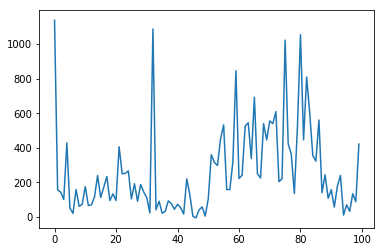

In [101]:
plt.plot(range(len(mean_window)),mean_window)
plt.show()

In [109]:
print len(mean_window)
print len(flux[:420500])
print len(flux)/len(mean_window)

100
420500
4205


In [106]:
div_window = []
for i in mean_window:
    for j in range(len(flux)/len(mean_window)):
        div_window.append(i)

In [107]:
print len(div_window)

420500
